In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import smogn
import h5py
from scipy.ndimage import gaussian_filter1d
from scipy.stats import pearsonr, ks_2samp
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import tarp

In [2]:
c = 3.*10**8

with h5py.File(r'C:\Users\tirth\OneDrive\Desktop\Projects\Halo - galaxy connection\data\groups_090.hdf5', 'r') as f:
    # Positions, velocities and masses of the halos
    M_h =   f['Group/Group_M_Crit200'][:]*1e10      #Msun/h
    R_h =   f['Group/Group_R_Crit200'][:]/c         #kpc/h
    V_h  =  f['Group/GroupVel'][:]                  #km/s
    V_h =   np.linalg.norm(V_h, axis = 1)
    ID_r =  f['Group/GroupFirstSub'][:] #Contains halos without gals as this number = -1
    ID_h =  np.arange(0, M_h.shape[0], 1, dtype = float) #It is the ID of the halos, to match the gal cat

    # Positions, stellar masses,  of the galaxies
    SM     = f['Subhalo/SubhaloMassType'][:, 4]*1e10 #Msun/h
    SFR    = f['Subhalo/SubhaloSFR'][:]*1e10 #Msun/yr
    SR = f['Subhalo/SubhaloHalfmassRadType'][:, 4]
    Colour = f['Subhalo/SubhaloStellarPhotometrics'][:, 4] - f['Subhalo/SubhaloStellarPhotometrics'][:, 5] #g-r 
    ID_g = np.array(f['Subhalo/SubhaloGrNr']) #Gals IDs

indexes = np.where( ID_r != -1)[0]
M_h = M_h[indexes]
R_h = R_h[indexes]
V_h = V_h[indexes]
ID_h = ID_h[indexes]

# Halo catalog
data = np.array( [ M_h, R_h, V_h, ID_h ] ).T
columns = [ 'M_h', 'R_h', 'V_h', 'ID' ] 
halos = pd.DataFrame(data = data, columns = columns)

indexes = np.where(SM > 0)[0]
SM = SM[indexes]
SFR = SFR[indexes]
SR = SR[indexes]
Colour = Colour[indexes]
ID_g = ID_g[indexes]

#Galaxy catalog
data = np.array([SM, SFR, Colour, SR, ID_g]).T
columns = ['SM', 'SFR', 'Colour', 'SR', 'ID']
gals = pd.DataFrame(data=data, columns=columns)

gals = gals.drop_duplicates(subset = ['ID'], keep = 'first')

gals['SFR'] = gals['SFR'].replace(0, 1)
gals['SFR'] = np.log10(gals['SFR'])
gals.loc[gals['SFR'] == 0, 'SFR'] = np.random.normal(8.0, 0.5, len(gals.loc[gals['SFR'] == 0]))
#gals.shape

#SM.shape, M_h.shape

df = pd.merge(left = halos, right = gals, left_on = 'ID', right_on = 'ID')

df['M_h'] = np.log10(df['M_h'])
df['R_h'] = np.log10(df['R_h'])
df['V_h'] = np.log10(df['V_h'])

df['SM']  = np.log10(df['SM'])
#df['SR']  = np.log10(df['SR'] + 0.01)

In [3]:
df.shape

(1522, 8)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True, dpi = 100)

fig.suptitle('Halo properties')

axs[0].hist(df['M_h'], bins = 40)
axs[0].set_yscale('log')
axs[0].set_xlabel('M_h')
axs[0].set_ylabel('# halos')

axs[1].hist(df['R_h'], bins = 40)
axs[1].set_yscale('log')
axs[1].set_xlabel('R_h')

axs[2].hist(df['V_h'], bins = 40)
axs[2].set_yscale('log')
axs[2].set_xlabel('V_h')

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True, dpi = 100)

fig.suptitle('Galaxy properties')

axs[0].hist(df['SM'], bins = 40)
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$M_{\star}$')
axs[0].set_ylabel('# halos')

axs[1].hist(df['Colour'], bins = 40)
axs[1].set_yscale('log')
axs[1].set_xlabel('Color')

axs[2].hist(df['SFR'], bins = 40)
axs[2].set_yscale('log')
axs[2].set_xlabel('SFR')

In [ ]:
def correlation_heatmap(df):
    correlations = df.corr(method = 'pearson')

    fig, ax = plt.subplots(figsize = (8,8))
    sns.heatmap(correlations, vmax = 1.0, center = 0, fmt = '.4f',
                square = True, linewidths = .5, annot = True, 
                cbar_kws = {"shrink": .82})
    plt.title('Pearson correlation Heatmap')
    plt.show()
    
    return correlations

correlation_heatmap(df)

In [4]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(SimpleMLP, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        
        self.fc_out = nn.Linear(hidden_size, output_size)
        
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))

        x = self.fc_out(x)
        return x

In [5]:
def train_neural_network(X_train, X_test, y_train, y_test, num_epochs=500):
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)
    if y_test.ndim == 1:
        y_test = y_test.reshape(-1, 1)

    mean_data = np.mean(X_train, axis=0)
    std_data = np.std(X_train, axis=0)
    
    X_train_norm = (X_train - mean_data) / std_data
    X_test_norm = (X_test - mean_data) / std_data

    mean_targets = np.mean(y_train, axis=0)
    std_targets = np.std(y_train, axis=0)
    
    y_train_norm = (y_train - mean_targets) / std_targets
    y_test_norm = (y_test - mean_targets) / std_targets

    X_train_tensor = torch.FloatTensor(X_train_norm.values if hasattr(X_train_norm, 'values') else X_train_norm)
    y_train_tensor = torch.FloatTensor(y_train_norm)
    X_test_tensor = torch.FloatTensor(X_test_norm.values if hasattr(X_test_norm, 'values') else X_test_norm)
    y_test_tensor = torch.FloatTensor(y_test_norm)

    input_size = X_train_tensor.shape[1]
    model = SimpleMLP(input_size, hidden_size=128)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Track losses
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            test_losses.append(test_loss.item())

    model.eval()
    with torch.no_grad():
        y_pred_norm = model(X_test_tensor).numpy()

    y_pred = y_pred_norm * std_targets + mean_targets
    
    metrics = {}
    for i in range(y_test.shape[1]):
        mse = mean_squared_error(y_test[:, i], y_pred[:, i])
        pearson_corr, pearson_pval = pearsonr(y_test[:, i], y_pred[:, i])
        ks_stat, ks_pval = ks_2samp(y_test[:, i], y_pred[:, i])
        
        metrics[f'target_{i}'] = {
            'MSE': mse,
            'Pearson_r': pearson_corr,
            'Pearson_pval': pearson_pval,
            'KS_statistic': ks_stat,
            'KS_pval': ks_pval
        }
    
    return y_pred, metrics, train_losses, test_losses

In [6]:
SM1 = df['SM'].values
SFR1 = df['SFR'].values
Colour1 = df['Colour'].values
SR1 = df['SR'].values

df1 = df.copy()
df1.drop(['SFR', 'Colour', 'SR'], axis=1, inplace=True)

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(df1, SM1, test_size=0.2, random_state=42)
X_train_sfr, X_test_sfr, y_train_sfr, y_test_sfr = train_test_split(df1, SFR1, test_size=0.2, random_state=42)
X_train_colour, X_test_colour, y_train_colour, y_test_colour = train_test_split(df1, Colour1, test_size=0.2, random_state=42)
X_train_sr, X_test_sr, y_train_sr, y_test_sr = train_test_split(df1, SR1, test_size=0.2, random_state=42)

In [7]:
X_train_colour.shape, X_test_colour.shape

((1217, 5), (305, 5))

In [ ]:
# Neural Network
y_raw_nn_sm, metrics_raw_nn_sm, train_loss_raw_nn_sm, test_loss_raw_nn_sm = train_neural_network(X_train_sm, X_test_sm, y_train_sm, y_test_sm)
y_raw_nn_sfr, metrics_raw_nn_sfr, train_loss_raw_nn_sfr, test_loss_raw_nn_sfr = train_neural_network(X_train_sfr, X_test_sfr, y_train_sfr, y_test_sfr)
y_raw_nn_colour, metrics_raw_nn_colour, train_loss_raw_nn_colour, test_loss_raw_nn_colour = train_neural_network(X_train_colour, X_test_colour, y_train_colour, y_test_colour)
y_raw_nn_sr, metrics_raw_nn_sr, train_loss_raw_nn_sr, test_loss_raw_nn_sr = train_neural_network(X_train_sr, X_test_sr, y_train_sr, y_test_sr)

In [ ]:
df_smogn = df.copy()

X = df_smogn.drop(['SM', 'SFR', 'Colour', 'SR'], axis=1)
y_sm = df_smogn[['SM']]
y_sfr = df_smogn[['SFR']]
y_colour = df_smogn[['Colour']]
y_sr = df_smogn[['SR']]

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y_sm, test_size=0.2, random_state=42)
X_train_sfr, X_test_sfr, y_train_sfr, y_test_sfr = train_test_split(X, y_sfr, test_size=0.2, random_state=42)
X_train_colour, X_test_colour, y_train_colour, y_test_colour = train_test_split(X, y_colour, test_size=0.2, random_state=42)
X_train_sr, X_test_sr, y_train_sr, y_test_sr = train_test_split(X, y_sr, test_size=0.2, random_state=42)

df_train_sm = X_train_sm.copy()
df_train_sm['SM'] = y_train_sm.values
df_train_sm = df_train_sm.reset_index(drop=True)

df_train_sfr = X_train_sfr.copy()
df_train_sfr['SFR'] = y_train_sfr.values
df_train_sfr = df_train_sfr.reset_index(drop=True)

df_train_colour = X_train_colour.copy()
df_train_colour['Colour'] = y_train_colour.values
df_train_colour = df_train_colour.reset_index(drop=True)

df_train_sr = X_train_sr.copy()
df_train_sr['SR'] = y_train_sr.values
df_train_sr = df_train_sr.reset_index(drop=True)

df_train_sm = smogn.smoter(
    data=df_train_sm,
    y='SM',
    k=3,                     # Further reduced from 5
    pert=0.01,              # Much more conservative
    samp_method='extreme',
    rel_method='manual',
    rel_ctrl_pts_rg=[
        [6.5, 0, 0],        # Low mass: zero
        [10.8, 0, 0],       # Mid-high mass: STILL zero
        [11.2, 0.8, 0],     # Sharp transition
        [11.4, 1, 0],       # Only the very highest
        [11.63, 1, 0]
    ],
    under_samp=True         # Critical for reducing common regions
)

# SFR: Dual focus on extreme low AND extreme high
df_train_sfr = smogn.smoter(
    data=df_train_sfr,
    y='SFR',
    k=5,
    pert=0.025,              # Reduced perturbation
    samp_method='extreme',
    rel_method='manual',
    rel_ctrl_pts_rg=[
        [-2.5, 1, 0],
        [-0.5, 1, 0],
        [2.0, 0, 0],         # Mid range: zero relevance
        [8.5, 0.8, 0],       # High SFR increase
        [9.2, 1, 0],         # Maximum for extreme high
        [9.57, 1, 0]
    ],
    under_samp=True
)

# Colour: Extreme tails only
df_train_colour = smogn.smoter(
    data=df_train_colour,
    y='Colour',
    k=5,
    pert=0.025,
    samp_method='extreme',
    rel_method='manual',
    rel_ctrl_pts_rg=[
        [-0.13, 0.9, 0],
        [0.3, 0, 0],         # Central zero
        [1.05, 0.7, 0],
        [1.25, 1, 0],
        [1.32, 1, 0]
    ],
    under_samp=True
)

# SR: High values
df_train_sr = smogn.smoter(
    data=df_train_sr,
    y='SR',
    k=5,
    pert=0.025,
    samp_method='extreme',
    rel_method='manual',
    rel_ctrl_pts_rg=[
        [-2.0, 0, 0],
        [0.5, 0, 0],
        [1.0, 0.6, 0],
        [1.3, 0.9, 0],
        [1.48, 1, 0]
    ],
    under_samp=True
)

print(f"Original dataset size: {len(df_smogn)}")
print(f"SM training set size after SMOGN: {len(df_train_sm)} (+{len(df_train_sm) - len(X_train_sm)})")
print(f"SFR training set size after SMOGN: {len(df_train_sfr)} (+{len(df_train_sfr) - len(X_train_sfr)})")
print(f"Colour training set size after SMOGN: {len(df_train_colour)} (+{len(df_train_colour) - len(X_train_colour)})")
print(f"SR training set size after SMOGN: {len(df_train_sr)} (+{len(df_train_sr) - len(X_train_sr)})")

X_train_sm = df_train_sm.drop(['SM'], axis=1)
y_train_sm = df_train_sm[['SM']].values

X_train_sfr = df_train_sfr.drop(['SFR'], axis=1)
y_train_sfr = df_train_sfr[['SFR']].values

X_train_colour = df_train_colour.drop(['Colour'], axis=1)
y_train_colour = df_train_colour[['Colour']].values

X_train_sr = df_train_sr.drop(['SR'], axis=1)
y_train_sr = df_train_sr[['SR']].values

X_test_sm = X_test_sm
y_test_sm = y_test_sm.values

X_test_sfr = X_test_sfr
y_test_sfr = y_test_sfr.values

X_test_colour = X_test_colour
y_test_colour = y_test_colour.values
X_test_sr = X_test_sr
y_test_sr = y_test_sr.valuesdf_train_sfr = X_train_sfr.copy()
df_train_sfr['SFR'] = y_train_sfr.values
df_train_sfr = df_train_sfr.reset_index(drop=True)

df_train_colour = X_train_colour.copy()
df_train_colour['Colour'] = y_train_colour.values
df_train_colour = df_train_colour.reset_index(drop=True)

df_train_sr = X_train_sr.copy()
df_train_sr['SR'] = y_train_sr.values
df_train_sr = df_train_sr.reset_index(drop=True)

df_train_sm = smogn.smoter(
    data=df_train_sm,
    y='SM',
    k=3,                     # Further reduced from 5
    pert=0.01,              # Much more conservative
    samp_method='extreme',
    rel_method='manual',
    rel_ctrl_pts_rg=[
        [6.5, 0, 0],        # Low mass: zero
        [10.8, 0, 0],       # Mid-high mass: STILL zero
        [11.2, 0.8, 0],     # Sharp transition
        [11.4, 1, 0],       # Only the very highest
        [11.63, 1, 0]
    ],
    under_samp=True         # Critical for reducing common regions
)

# SFR: Dual focus on extreme low AND extreme high
df_train_sfr = smogn.smoter(
    data=df_train_sfr,
    y='SFR',
    k=5,
    pert=0.025,              # Reduced perturbation
    samp_method='extreme',
    rel_method='manual',
    rel_ctrl_pts_rg=[
        [-2.5, 1, 0],
        [-0.5, 1, 0],
        [2.0, 0, 0],         # Mid range: zero relevance
        [8.5, 0.8, 0],       # High SFR increase
        [9.2, 1, 0],         # Maximum for extreme high
        [9.57, 1, 0]
    ],
    under_samp=True
)

# Colour: Extreme tails only
df_train_colour = smogn.smoter(
    data=df_train_colour,
    y='Colour',
    k=5,
    pert=0.025,
    samp_method='extreme',
    rel_method='manual',
    rel_ctrl_pts_rg=[
        [-0.13, 0.9, 0],
        [0.3, 0, 0],         # Central zero
        [1.05, 0.7, 0],
        [1.25, 1, 0],
        [1.32, 1, 0]
    ],
    under_samp=True
)

# SR: High values
df_train_sr = smogn.smoter(
    data=df_train_sr,
    y='SR',
    k=5,
    pert=0.025,
    samp_method='extreme',
    rel_method='manual',
    rel_ctrl_pts_rg=[
        [-2.0, 0, 0],
        [0.5, 0, 0],
        [1.0, 0.6, 0],
        [1.3, 0.9, 0],
        [1.48, 1, 0]
    ],
    under_samp=True
)

print(f"Original dataset size: {len(df_smogn)}")
print(f"SM training set size after SMOGN: {len(df_train_sm)} (+{len(df_train_sm) - len(X_train_sm)})")
print(f"SFR training set size after SMOGN: {len(df_train_sfr)} (+{len(df_train_sfr) - len(X_train_sfr)})")
print(f"Colour training set size after SMOGN: {len(df_train_colour)} (+{len(df_train_colour) - len(X_train_colour)})")
print(f"SR training set size after SMOGN: {len(df_train_sr)} (+{len(df_train_sr) - len(X_train_sr)})")

X_train_sm = df_train_sm.drop(['SM'], axis=1)
y_train_sm = df_train_sm[['SM']].values

X_train_sfr = df_train_sfr.drop(['SFR'], axis=1)
y_train_sfr = df_train_sfr[['SFR']].values

X_train_colour = df_train_colour.drop(['Colour'], axis=1)
y_train_colour = df_train_colour[['Colour']].values

X_train_sr = df_train_sr.drop(['SR'], axis=1)
y_train_sr = df_train_sr[['SR']].values

X_test_sm = X_test_sm
y_test_sm = y_test_sm.values

X_test_sfr = X_test_sfr
y_test_sfr = y_test_sfr.values

X_test_colour = X_test_colour
y_test_colour = y_test_colour.values

X_test_sr = X_test_sr
y_test_sr = y_test_sr.values

r_index: 100%|##########| 319/319 [00:00<00:00, 1872.23it/s]

Original dataset size: 1522
SM training set size after SMOGN: 2423 (+1206)
SFR training set size after SMOGN: 1217 (+0)
Colour training set size after SMOGN: 2406 (+1189)
SR training set size after SMOGN: 1080 (+-137)


In [8]:
# Neural Network
y_smogn_nn_sm, metrics_smogn_nn_sm, train_loss_smogn_nn_sm, test_loss_smogn_nn_sm = train_neural_network(X_train_sm, X_test_sm, y_train_sm, y_test_sm)
y_smogn_nn_sfr, metrics_smogn_nn_sfr, train_loss_smogn_nn_sfr, test_loss_smogn_nn_sfr = train_neural_network(X_train_sfr, X_test_sfr, y_train_sfr, y_test_sfr)
y_smogn_nn_colour, metrics_smogn_nn_colour, train_loss_smogn_nn_colour, test_loss_smogn_nn_colour = train_neural_network(X_train_colour, X_test_colour, y_train_colour, y_test_colour)
y_smogn_nn_sr, metrics_smogn_nn_sr, train_loss_smogn_nn_sr, test_loss_smogn_nn_sr = train_neural_network(X_train_sr, X_test_sr, y_train_sr, y_test_sr)

In [9]:
halos = df[['M_h', 'R_h', 'V_h']]
gals = df[['SM', 'SFR', 'Colour', 'SR']]

halos_train, halos_test, gals_train, gals_test = train_test_split(halos, gals, test_size=0.2, random_state=42)

In [10]:
halos_scalar = StandardScaler()
gals_scalar = StandardScaler()

halos_train = halos_scalar.fit_transform(halos_train)
halos_test = halos_scalar.transform(halos_test)
gals_train = gals_scalar.fit_transform(gals_train)
gals_test = gals_scalar.transform(gals_test)

halos_train_scaled = torch.tensor(halos_train, dtype=torch.float32)
halos_test_scaled = torch.tensor(halos_test, dtype=torch.float32)
gals_train_scaled = torch.tensor(gals_train, dtype=torch.float32)
gals_test_scaled = torch.tensor(gals_test, dtype=torch.float32)

In [11]:
halos_dim = 3
gals_dim = 4

dist_base = dist.Normal(torch.zeros(halos_dim), torch.ones(halos_dim) * 0.2).to_event(1)
x1_transform = T.spline(halos_dim)
x3_transform = T.affine_coupling(halos_dim)
dist_x1 = dist.TransformedDistribution(dist_base, [x1_transform, x3_transform]) 

x2_transform = T.conditional_spline(gals_dim, context_dim=halos_dim)
dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist.Normal(torch.zeros(gals_dim), 
                                            torch.ones(gals_dim) * 0.2).to_event(1), [x2_transform])

In [12]:
steps = 1301
modules = torch.nn.ModuleList([x1_transform, x3_transform, x2_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=1e-2)

running_loss = 0
for step in range(steps+1):
    optimizer.zero_grad()
    ln_p_x1 = dist_x1.log_prob(halos_train_scaled)
    ln_p_x2_given_x1 = dist_x2_given_x1.condition(halos_train_scaled.detach()).log_prob(gals_train_scaled.detach())
    loss = -(ln_p_x1 + ln_p_x2_given_x1).mean()
    loss.backward()
    optimizer.step()
    dist_x1.clear_cache()
    dist_x2_given_x1.clear_cache()
    running_loss += 10**loss.item()
    
    if step % 100 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 103.92662811279297
step: 100, loss: 15.65063762664795
step: 200, loss: 15.936668395996094
step: 300, loss: 13.7095365524292
step: 400, loss: 13.562004089355469
step: 500, loss: 14.115915298461914
step: 600, loss: 13.355199813842773
step: 700, loss: 13.917853355407715
step: 800, loss: 13.36984634399414
step: 900, loss: 12.715656280517578
step: 1000, loss: 13.709345817565918
step: 1100, loss: 13.690103530883789
step: 1200, loss: 14.351776123046875
step: 1300, loss: 12.442583084106445


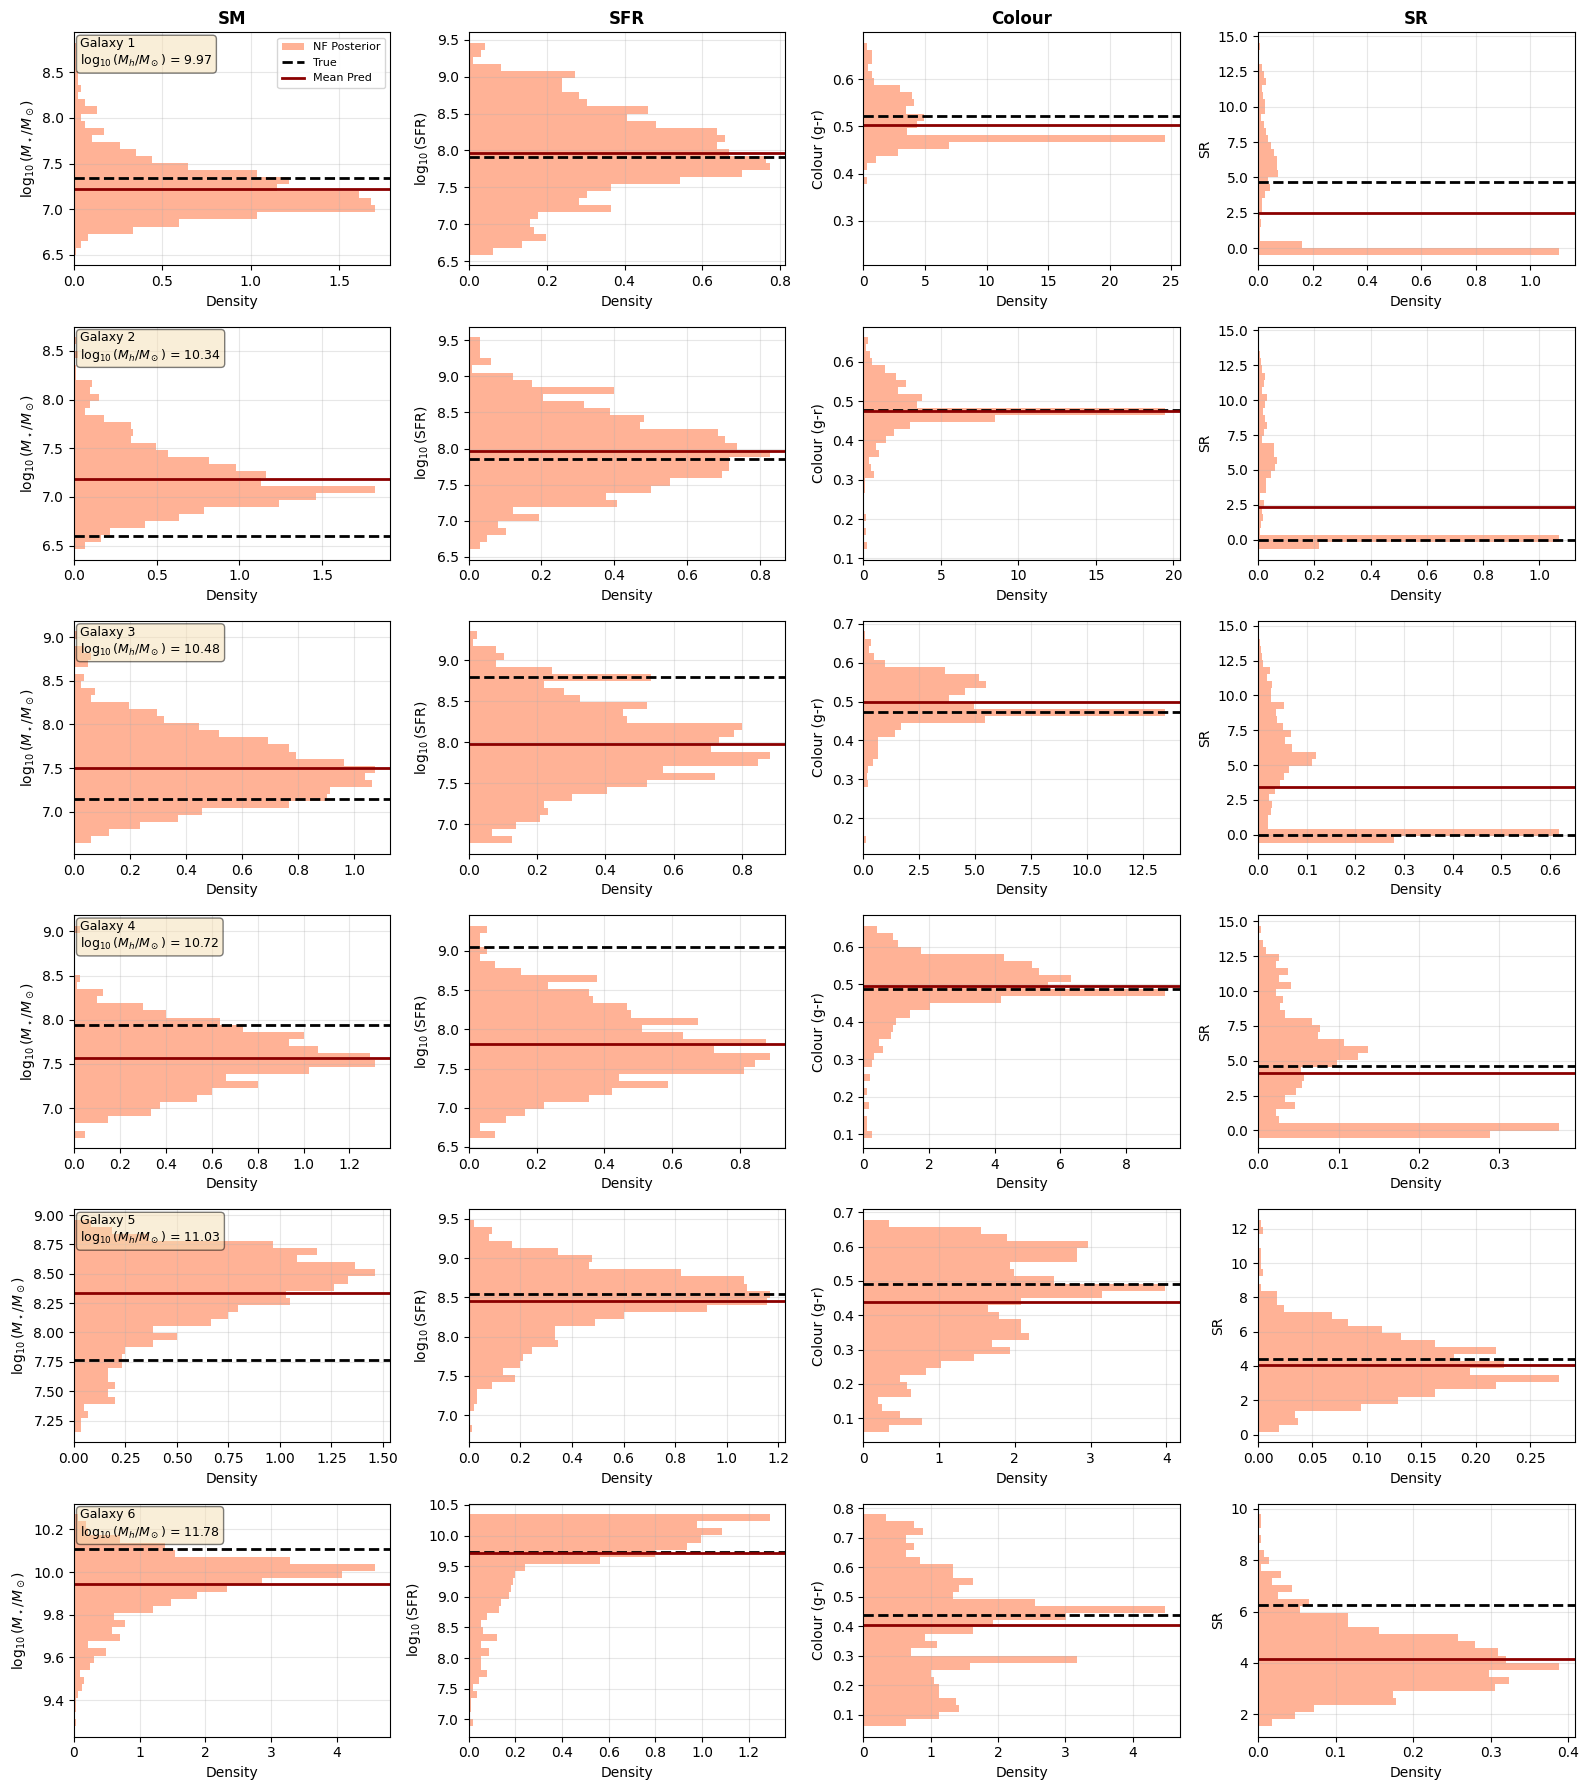


=== Summary Statistics for 6 Sample Galaxies ===

Galaxy 1:
  Halo Mass (log10): 9.969
  SM: True=7.341, Mean=7.223, Std=0.309
  SFR: True=7.918, Mean=7.969, Std=0.570
  Colour: True=0.522, Mean=0.502, Std=0.050
  SR: True=4.674, Mean=2.516, Std=3.792

Galaxy 2:
  Halo Mass (log10): 10.339
  SM: True=6.599, Mean=7.185, Std=0.331
  SFR: True=7.862, Mean=7.965, Std=0.518
  Colour: True=0.477, Mean=0.474, Std=0.064
  SR: True=0.000, Mean=2.306, Std=3.716

Galaxy 3:
  Halo Mass (log10): 10.482
  SM: True=7.146, Mean=7.498, Std=0.386
  SFR: True=8.797, Mean=7.976, Std=0.505
  Colour: True=0.474, Mean=0.498, Std=0.061
  SR: True=0.000, Mean=3.428, Std=3.834

Galaxy 4:
  Halo Mass (log10): 10.718
  SM: True=7.941, Mean=7.568, Std=0.331
  SFR: True=9.051, Mean=7.812, Std=0.495
  Colour: True=0.488, Mean=0.495, Std=0.078
  SR: True=4.628, Mean=4.130, Std=3.774

Galaxy 5:
  Halo Mass (log10): 11.034
  SM: True=7.767, Mean=8.334, Std=0.342
  SFR: True=8.545, Mean=8.459, Std=0.423
  Colour: True=

In [13]:
# Select 6 diverse galaxies from test set (spanning different halo masses)
n_samples = 6
n_posterior_samples = 1000

# Select galaxies at different percentiles of halo mass for diversity
percentiles = [5, 25, 40, 60, 80, 95]
indices = []
halo_masses_unscaled = halos_scalar.inverse_transform(halos_test)[:, 0]  # M_h column
for p in percentiles:
    idx = np.argmin(np.abs(halo_masses_unscaled - np.percentile(halo_masses_unscaled, p)))
    indices.append(idx)

# Generate posterior samples for these 6 galaxies
posterior_samples = {}
for i, idx in enumerate(indices):
    halo_i = torch.tensor(halos_test[idx:idx+1], dtype=torch.float32)
    
    # Generate posterior samples
    with torch.no_grad():
        gals_posterior_i = dist_x2_given_x1.condition(halo_i).sample(torch.Size([n_posterior_samples]))
    
    # Inverse transform to original space
    gals_posterior_unscaled = gals_scalar.inverse_transform(gals_posterior_i.squeeze(1).detach().cpu().numpy())
    
    posterior_samples[i] = {
        'halo_mass': halo_masses_unscaled[idx],
        'halo_features': halos_scalar.inverse_transform(halos_test[idx:idx+1])[0],
        'true_gals': gals_scalar.inverse_transform(gals_test[idx:idx+1])[0],
        'posterior': gals_posterior_unscaled  # Shape: (n_posterior_samples, 4)
    }

# Plot the posteriors
fig, axes = plt.subplots(n_samples, 4, figsize=(16, 3*n_samples))
property_names = ['SM', 'SFR', 'Colour', 'SR']
property_labels = [r'$\log_{10}(M_\star/M_\odot)$', r'$\log_{10}$(SFR)', 'Colour (g-r)', 'SR']

for i in range(n_samples):
    halo_mass = posterior_samples[i]['halo_mass']
    true_vals = posterior_samples[i]['true_gals']
    posterior = posterior_samples[i]['posterior']
    
    for j, (pname, plabel) in enumerate(zip(property_names, property_labels)):
        ax = axes[i, j]
        
        # Create density plot on the left
        # Histogram/KDE of posterior
        ax.hist(posterior[:, j], bins=30, orientation='horizontal', 
                color='coral', alpha=0.6, density=True, label='NF Posterior')
        
        # Mark the true value
        ax.axhline(true_vals[j], color='black', linestyle='--', linewidth=2, label='True')
        
        # Mark the mean prediction
        mean_pred = posterior[:, j].mean()
        ax.axhline(mean_pred, color='darkred', linestyle='-', linewidth=2, label='Mean Pred')
        
        ax.set_xlabel('Density', fontsize=10)
        ax.set_ylabel(plabel, fontsize=10)
        
        # Add title showing halo mass
        if j == 0:
            ax.text(0.02, 0.98, f'Galaxy {i+1}\n' + r'$\log_{10}(M_h/M_\odot)$' + f' = {halo_mass:.2f}',
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=9)
        
        if i == 0:
            ax.set_title(pname, fontsize=12, fontweight='bold')
        
        if i == 0 and j == 0:
            ax.legend(loc='upper right', fontsize=8)
        
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Summary Statistics for 6 Sample Galaxies ===\n")
for i in range(n_samples):
    print(f"Galaxy {i+1}:")
    print(f"  Halo Mass (log10): {posterior_samples[i]['halo_mass']:.3f}")
    for j, pname in enumerate(property_names):
        true_val = posterior_samples[i]['true_gals'][j]
        post = posterior_samples[i]['posterior'][:, j]
        mean_pred = post.mean()
        std_pred = post.std()
        print(f"  {pname}: True={true_val:.3f}, Mean={mean_pred:.3f}, Std={std_pred:.3f}")
    print()

Generating NF predictions for the test set...
NF predictions generated!

Computing metrics for SM...
Computing metrics for SFR...
Computing metrics for Colour...
Computing metrics for SR...

Metrics computation complete!



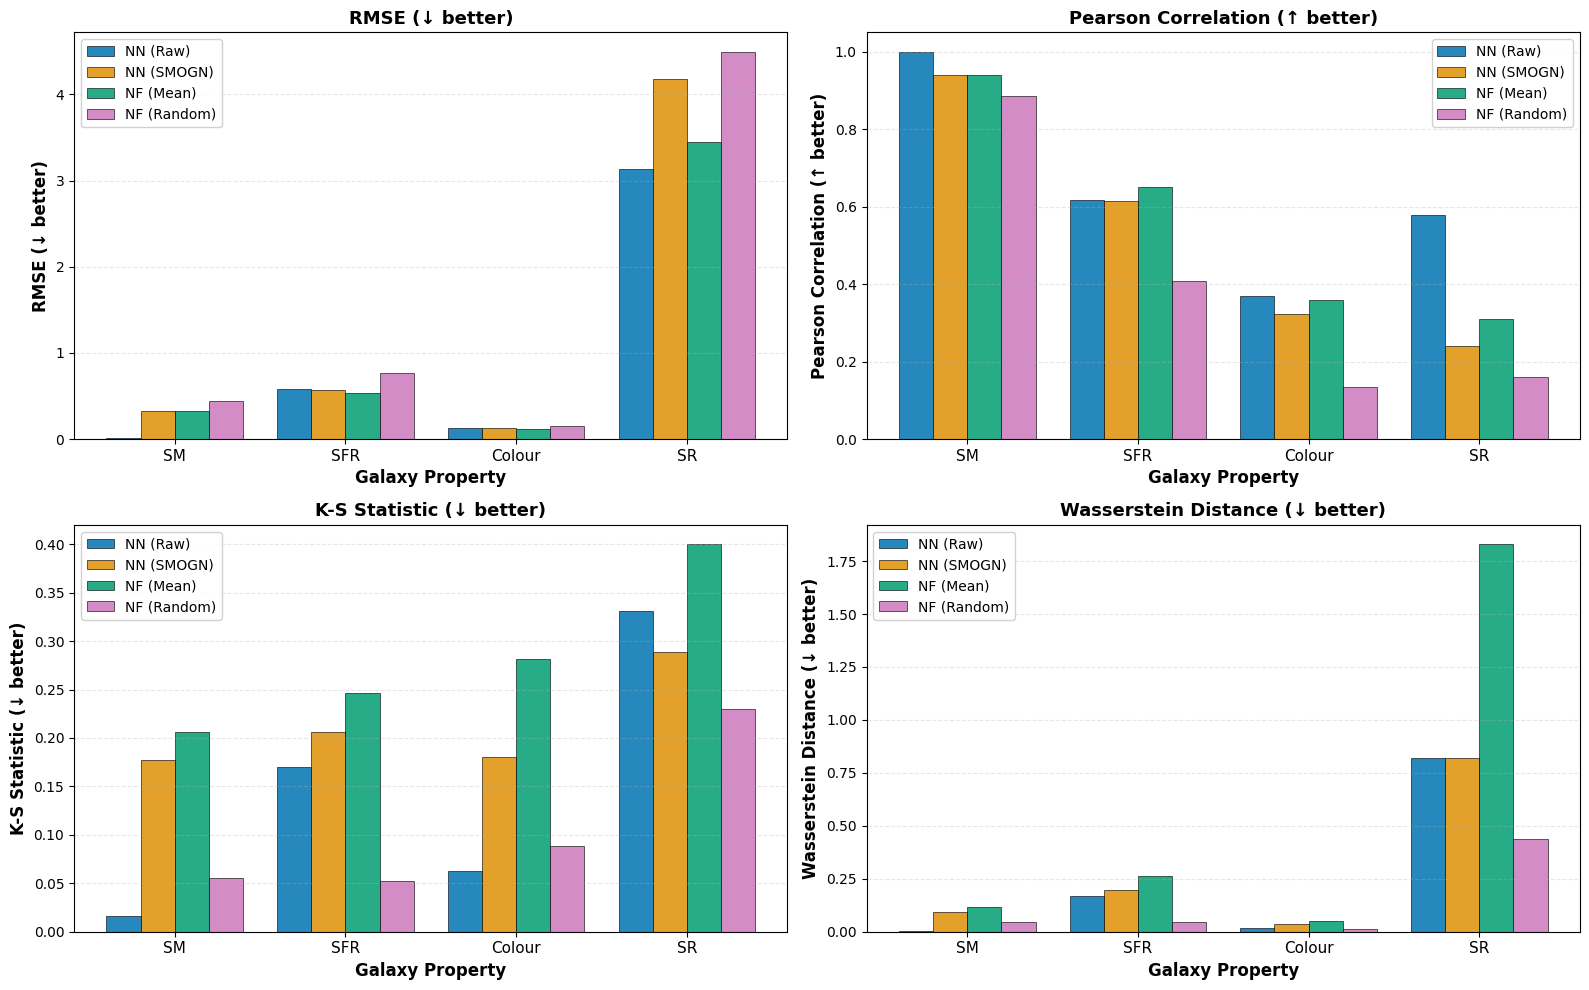

In [ ]:
from scipy.stats import wasserstein_distance

# ============================================
# Step 1: Generate NF Predictions (Mean and Random)
# ============================================

print("Generating NF predictions for the test set...")
ntest = len(halos_test)
gals_pred_nf_mean = np.zeros((ntest, 4))
gals_pred_nf_random = np.zeros((ntest, 4))

n_posterior_samples = 1000

for i in range(ntest):
    halo_i = torch.tensor(halos_test[i:i+1], dtype=torch.float32)
    
    # Generate posterior samples
    with torch.no_grad():
        gals_posterior_i = dist_x2_given_x1.condition(halo_i).sample(torch.Size([n_posterior_samples]))
    
    # Inverse transform to original space
    gals_posterior_unscaled = gals_scalar.inverse_transform(gals_posterior_i.squeeze(1).detach().cpu().numpy())
    
    # Mean prediction
    gals_pred_nf_mean[i] = gals_posterior_unscaled.mean(axis=0)
    
    # Random sample prediction
    random_idx = np.random.randint(0, n_posterior_samples)
    gals_pred_nf_random[i] = gals_posterior_unscaled[random_idx]
    
    '''if (i+1) % 50 == 0:
        print(f"  Processed {i+1}/{ntest} galaxies...")'''

print("NF predictions generated!\n")

# ============================================
# Step 2: Organize All Predictions
# ============================================

properties = ['SM', 'SFR', 'Colour', 'SR']

# True values
y_true = {
    'SM': y_test_sm.flatten(),
    'SFR': y_test_sfr.flatten(),
    'Colour': y_test_colour.flatten(),
    'SR': y_test_sr.flatten()
}

# NN Raw predictions
y_nn_raw_predictions = {
    'SM': y_raw_nn_sm.flatten(),
    'SFR': y_raw_nn_sfr.flatten(),
    'Colour': y_raw_nn_colour.flatten(),
    'SR': y_raw_nn_sr.flatten()
}

# NN SMOGN predictions
y_nn_smogn_predictions = {
    'SM': y_smogn_nn_sm.flatten(),
    'SFR': y_smogn_nn_sfr.flatten(),
    'Colour': y_smogn_nn_colour.flatten(),
    'SR': y_smogn_nn_sr.flatten()
}

# NF Mean predictions
y_nf_mean_predictions = {
    'SM': gals_pred_nf_mean[:, 0],
    'SFR': gals_pred_nf_mean[:, 1],
    'Colour': gals_pred_nf_mean[:, 2],
    'SR': gals_pred_nf_mean[:, 3]
}

# NF Random predictions
y_nf_random_predictions = {
    'SM': gals_pred_nf_random[:, 0],
    'SFR': gals_pred_nf_random[:, 1],
    'Colour': gals_pred_nf_random[:, 2],
    'SR': gals_pred_nf_random[:, 3]
}

# ============================================
# Step 3: Compute Metrics
# ============================================

def compute_all_metrics(y_true, y_pred):
    """Compute RMSE, PCC, K-S test, and Wasserstein distance"""
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Pearson Correlation Coefficient
    pcc, pcc_pval = pearsonr(y_true, y_pred)
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_pval = ks_2samp(y_true, y_pred)
    
    # Wasserstein distance
    wass_dist = wasserstein_distance(y_true, y_pred)
    
    return {
        'RMSE': rmse,
        'PCC': pcc,
        'PCC_pval': pcc_pval,
        'KS_stat': ks_stat,
        'KS_pval': ks_pval,
        'Wasserstein': wass_dist
    }

# Compute metrics for all properties and all models
metrics_comparison = {prop: {} for prop in properties}

for prop in properties:
    print(f"Computing metrics for {prop}...")
    
    # NN Raw metrics
    metrics_comparison[prop]['NN_Raw'] = compute_all_metrics(
        y_true[prop], 
        y_nn_raw_predictions[prop]
    )
    
    # NN SMOGN metrics
    metrics_comparison[prop]['NN_SMOGN'] = compute_all_metrics(
        y_true[prop], 
        y_nn_smogn_predictions[prop]
    )
    
    # NF Mean metrics
    metrics_comparison[prop]['NF_Mean'] = compute_all_metrics(
        y_true[prop], 
        y_nf_mean_predictions[prop]
    )
    
    # NF Random metrics
    metrics_comparison[prop]['NF_Random'] = compute_all_metrics(
        y_true[prop], 
        y_nf_random_predictions[prop]
    )

print("\nMetrics computation complete!\n")

'''# ============================================
# Step 4: Display Results in Table Format
# ============================================

print("=" * 100)
print("METRICS COMPARISON: NN (Raw) vs NN (SMOGN) vs NF (Mean) vs NF (Random)")
print("=" * 100)

for prop in properties:
    print(f"\n{'='*100}")
    print(f"Property: {prop}")
    print(f"{'='*100}")
    print(f"{'Metric':<20} {'NN (Raw)':<20} {'NN (SMOGN)':<20} {'NF (Mean)':<20} {'NF (Random)':<20}")
    print("-" * 100)
    
    for metric in ['RMSE', 'PCC', 'KS_stat', 'Wasserstein']:
        nn_raw_val = metrics_comparison[prop]['NN_Raw'][metric]
        nn_smogn_val = metrics_comparison[prop]['NN_SMOGN'][metric]
        nf_mean_val = metrics_comparison[prop]['NF_Mean'][metric]
        nf_random_val = metrics_comparison[prop]['NF_Random'][metric]
        
        print(f"{metric:<20} {nn_raw_val:<20.6f} {nn_smogn_val:<20.6f} {nf_mean_val:<20.6f} {nf_random_val:<20.6f}")'''

# ============================================
# Step 5: Visualize Comparison (IMPROVED COLORS)
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

metrics_to_plot = ['RMSE', 'PCC', 'KS_stat', 'Wasserstein']
metric_labels = ['RMSE (↓ better)', 'Pearson Correlation (↑ better)', 
                 'K-S Statistic (↓ better)', 'Wasserstein Distance (↓ better)']

colors = {
    'NN_Raw': '#0173B2',        # Blue
    'NN_SMOGN': '#DE8F05',      # Orange
    'NF_Mean': '#029E73',       # Green
    'NF_Random': '#CC78BC'      # Pink/Purple
}

for idx, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    ax = axes[idx]
    
    # Extract values for each property
    nn_raw_vals = [metrics_comparison[prop]['NN_Raw'][metric] for prop in properties]
    nn_smogn_vals = [metrics_comparison[prop]['NN_SMOGN'][metric] for prop in properties]
    nf_mean_vals = [metrics_comparison[prop]['NF_Mean'][metric] for prop in properties]
    nf_random_vals = [metrics_comparison[prop]['NF_Random'][metric] for prop in properties]
    
    x = np.arange(len(properties))
    width = 0.2
    
    # Create grouped bar chart with improved colors
    ax.bar(x - 1.5*width, nn_raw_vals, width, label='NN (Raw)', 
           color=colors['NN_Raw'], alpha=0.85, edgecolor='black', linewidth=0.5)
    ax.bar(x - 0.5*width, nn_smogn_vals, width, label='NN (SMOGN)', 
           color=colors['NN_SMOGN'], alpha=0.85, edgecolor='black', linewidth=0.5)
    ax.bar(x + 0.5*width, nf_mean_vals, width, label='NF (Mean)', 
           color=colors['NF_Mean'], alpha=0.85, edgecolor='black', linewidth=0.5)
    ax.bar(x + 1.5*width, nf_random_vals, width, label='NF (Random)', 
           color=colors['NF_Random'], alpha=0.85, edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel('Galaxy Property', fontsize=12, fontweight='bold')
    ax.set_ylabel(label, fontsize=12, fontweight='bold')
    ax.set_title(label, fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(properties, fontsize=11)
    ax.legend(fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.show()

Generating 2x2 grid contour plots...
  Plotting SM vs SFR...


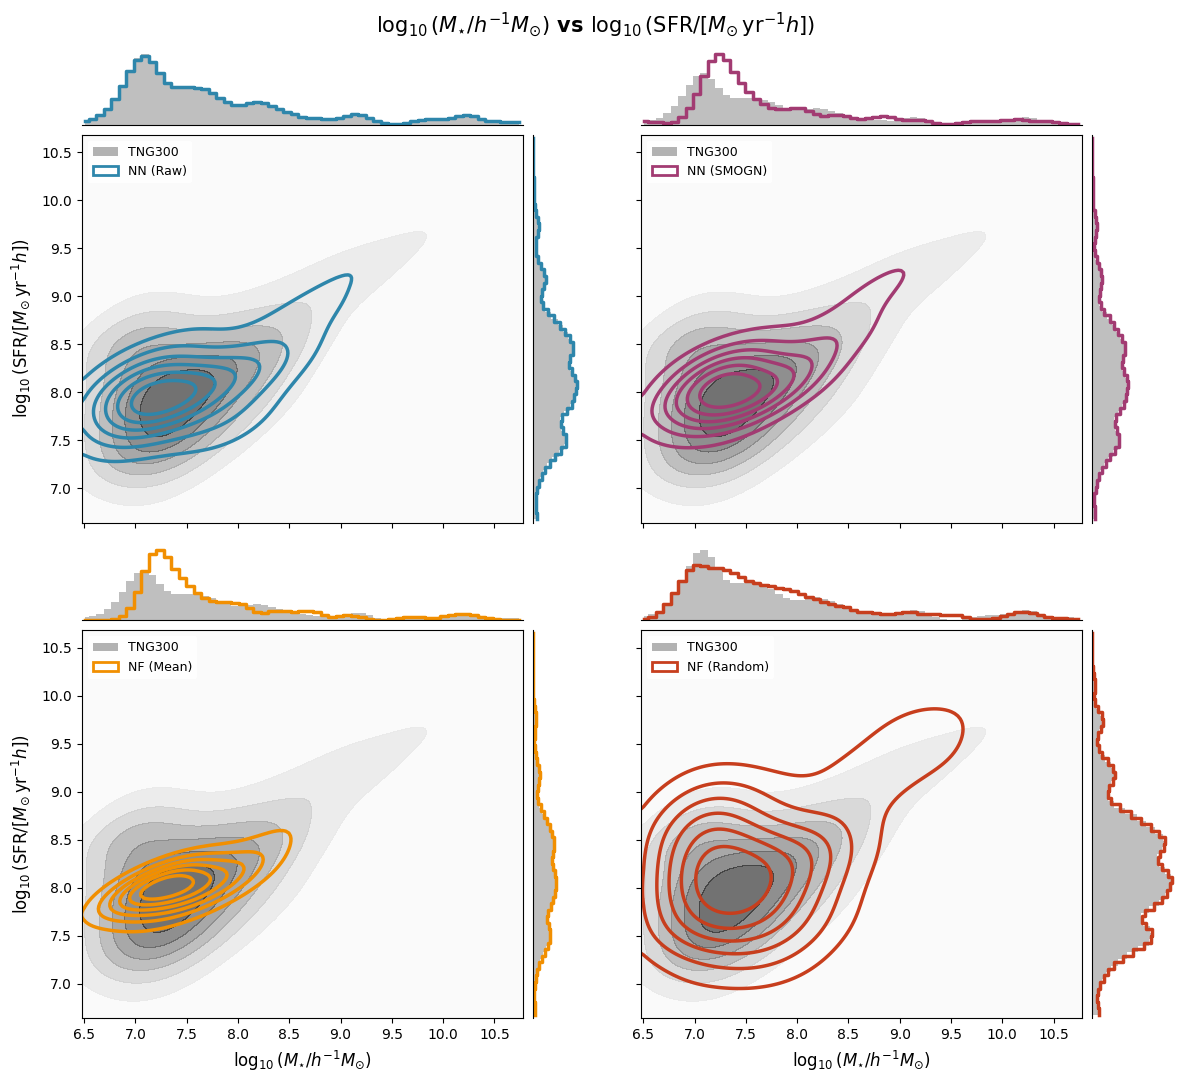

  Plotting SM vs Colour...


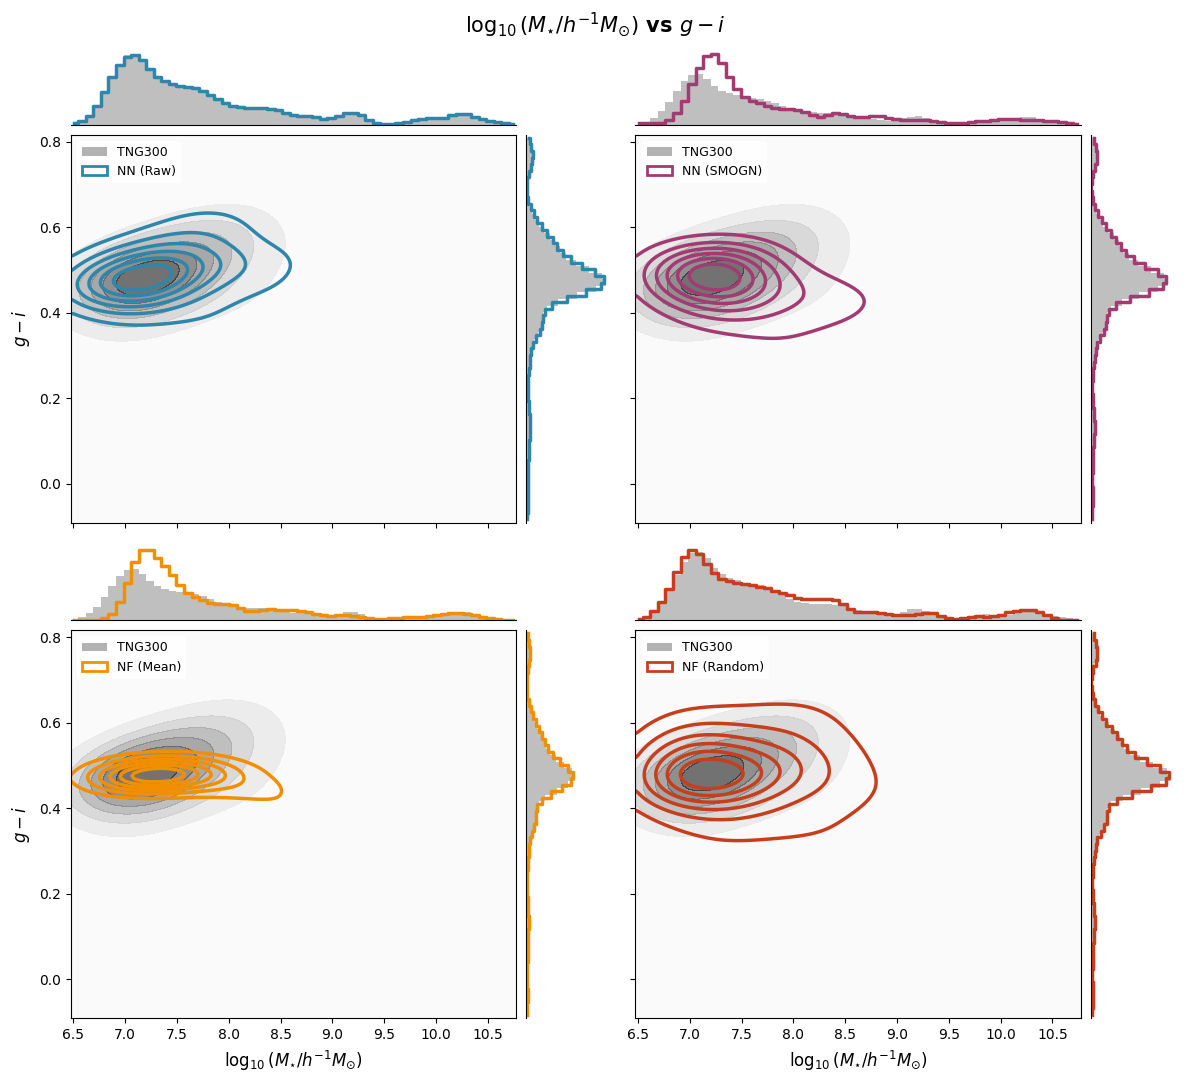

  Plotting SFR vs Colour...


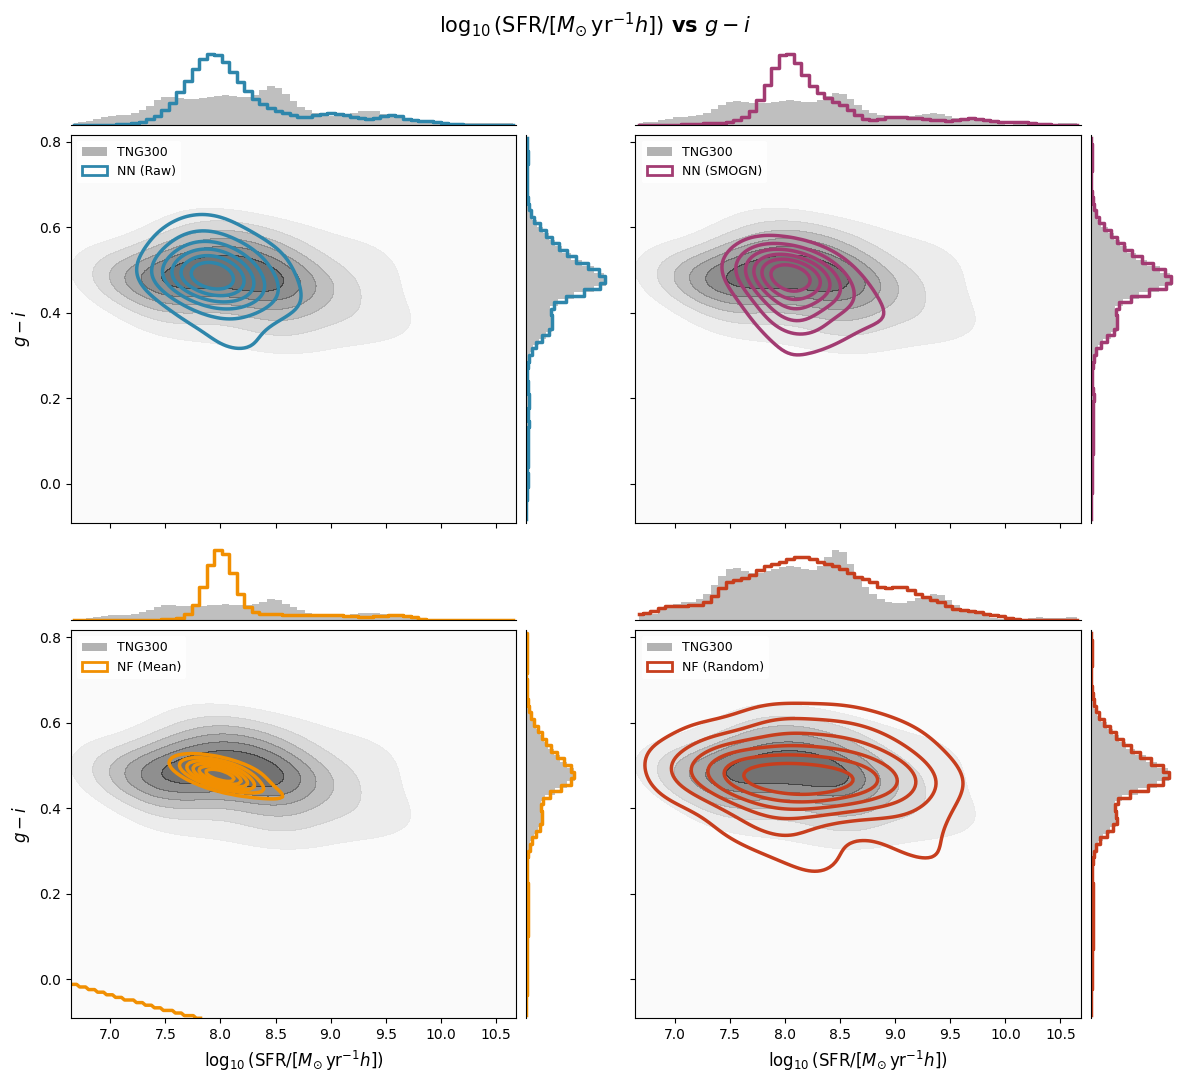

  Plotting SM vs SR...


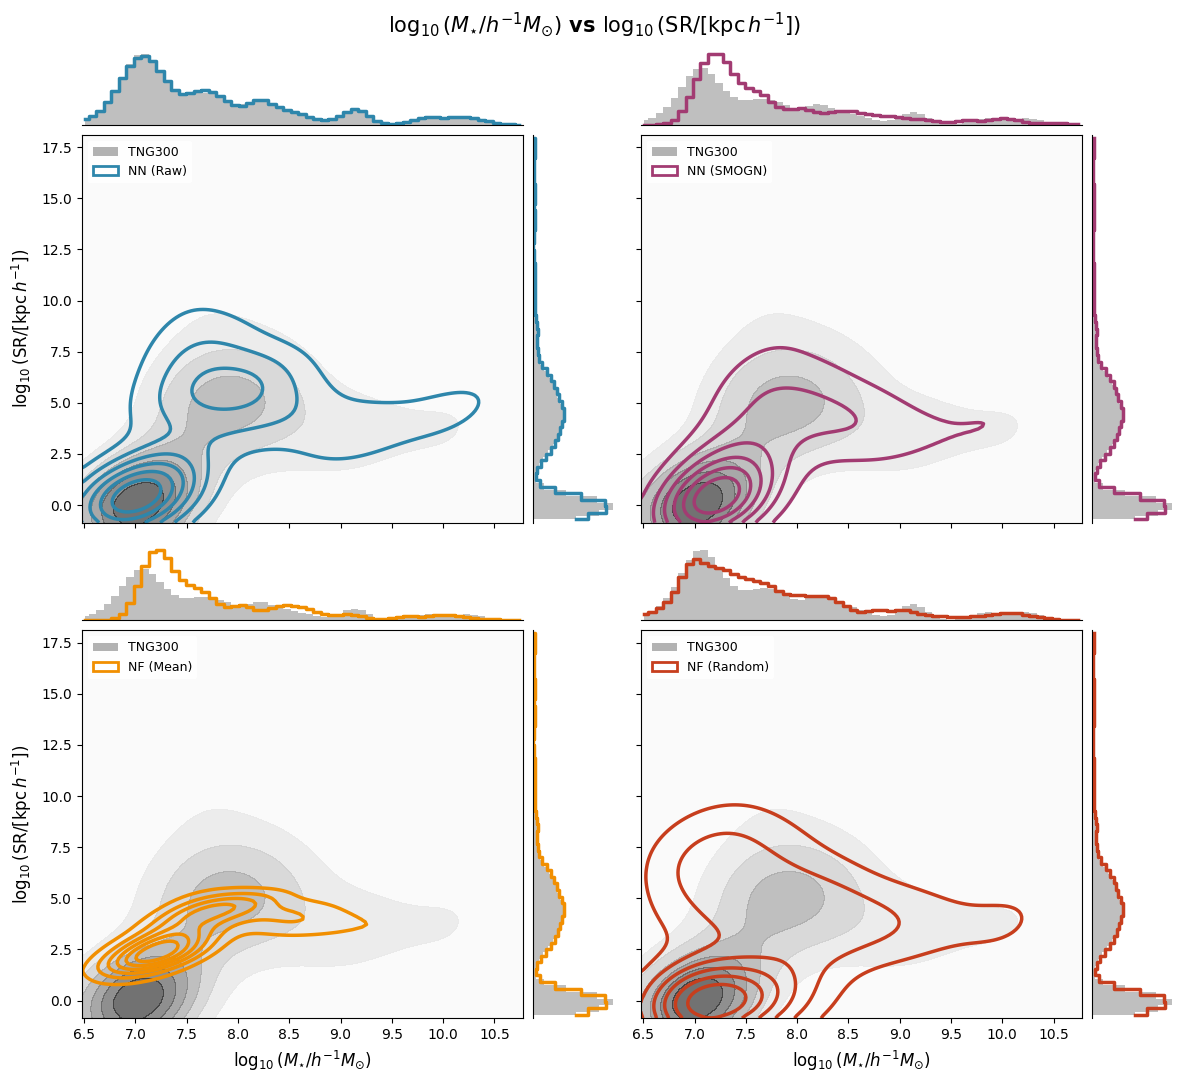

In [26]:
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter

def plot_2d_contour_2x2_grid(prop1, prop2, xlabel, ylabel, subsample_fraction=0.5):
    """
    Create 2x2 grid showing all 4 models for a property pair
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 11))
    axes = axes.flatten()
    
    # Get true data
    x_true = y_true[prop1]
    y_true_data = y_true[prop2]
    
    # Subsample for efficiency
    n_samples = len(x_true)
    n_subsample = int(n_samples * subsample_fraction)
    subsample_idx = np.random.choice(n_samples, n_subsample, replace=False)
    
    x_true_sub = x_true[subsample_idx]
    y_true_sub = y_true_data[subsample_idx]
    
    # Define plot limits
    x_min, x_max = np.percentile(x_true, [0.5, 99.5])
    y_min, y_max = np.percentile(y_true_data, [0.5, 99.5])
    x_range = x_max - x_min
    y_range = y_max - y_min
    xlim = [x_min - 0.05*x_range, x_max + 0.05*x_range]
    ylim = [y_min - 0.05*y_range, y_max + 0.05*y_range]
    
    # Create finer grid for smoother contours
    xx, yy = np.mgrid[xlim[0]:xlim[1]:150j, ylim[0]:ylim[1]:150j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    
    # Compute KDE for true distribution
    try:
        kernel_true = gaussian_kde(np.vstack([x_true_sub, y_true_sub]), bw_method='scott')
        density_true = np.reshape(kernel_true(positions).T, xx.shape)
        density_true = gaussian_filter(density_true, sigma=1.0)
    except:
        print(f"KDE failed for true data, using histogram instead")
        density_true, _, _ = np.histogram2d(x_true_sub, y_true_sub, bins=50)
        density_true = gaussian_filter(density_true.T, sigma=2.0)
    
    # Models to plot
    model_list = ['NN (Raw)', 'NN (SMOGN)', 'NF (Mean)', 'NF (Random)']
    
    for idx, model_name in enumerate(model_list):
        ax = axes[idx]
        
        # Get predictions
        x_pred = models[model_name][prop1][subsample_idx]
        y_pred = models[model_name][prop2][subsample_idx]
        
        # Compute KDE for predictions
        try:
            kernel_pred = gaussian_kde(np.vstack([x_pred, y_pred]), bw_method='scott')
            density_pred = np.reshape(kernel_pred(positions).T, xx.shape)
            density_pred = gaussian_filter(density_pred, sigma=1.0)
        except:
            print(f"KDE failed for {model_name}, using histogram instead")
            density_pred, _, _ = np.histogram2d(x_pred, y_pred, bins=50)
            density_pred = gaussian_filter(density_pred.T, sigma=2.0)
        
        # Plot true distribution (filled contours)
        levels_true = np.linspace(density_true.min(), density_true.max(), 8)
        ax.contourf(xx, yy, density_true, levels=levels_true,
                   cmap='Greys', alpha=0.6, zorder=1)
        
        # Plot model predictions (colored contours)
        levels_pred = np.linspace(density_pred.min(), density_pred.max(), 8)
        ax.contour(xx, yy, density_pred, levels=levels_pred,
                  colors=model_colors[model_name], 
                  linewidths=2.5, zorder=2)
        
        # Create marginal axes
        divider = make_axes_locatable(ax)
        ax_top = divider.append_axes("top", size="20%", pad=0.1)
        ax_right = divider.append_axes("right", size="20%", pad=0.1)
        
        # Top marginal (smooth histogram for x)
        bins_x = np.linspace(xlim[0], xlim[1], 60)
        hist_true_x, _ = np.histogram(x_true_sub, bins=bins_x, density=True)
        hist_pred_x, _ = np.histogram(x_pred, bins=bins_x, density=True)
        
        hist_true_x_smooth = gaussian_filter(hist_true_x, sigma=1.5)
        hist_pred_x_smooth = gaussian_filter(hist_pred_x, sigma=1.5)
        
        bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
        
        ax_top.fill_between(bin_centers_x, hist_true_x_smooth, 
                            color='gray', alpha=0.5, step='mid', linewidth=0)
        ax_top.plot(bin_centers_x, hist_pred_x_smooth, 
                   color=model_colors[model_name], linewidth=2.5, drawstyle='steps-mid')
        
        ax_top.set_xlim(xlim)
        ax_top.set_ylim(0, max(hist_true_x_smooth.max(), hist_pred_x_smooth.max()) * 1.1)
        ax_top.tick_params(labelbottom=False, labelleft=False, 
                          bottom=False, left=False, top=False, right=False)
        ax_top.spines['top'].set_visible(False)
        ax_top.spines['right'].set_visible(False)
        ax_top.spines['left'].set_visible(False)
        
        # Right marginal (smooth histogram for y)
        bins_y = np.linspace(ylim[0], ylim[1], 60)
        hist_true_y, _ = np.histogram(y_true_sub, bins=bins_y, density=True)
        hist_pred_y, _ = np.histogram(y_pred, bins=bins_y, density=True)
        
        hist_true_y_smooth = gaussian_filter(hist_true_y, sigma=1.5)
        hist_pred_y_smooth = gaussian_filter(hist_pred_y, sigma=1.5)
        
        bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
        
        ax_right.fill_betweenx(bin_centers_y, hist_true_y_smooth, 
                               color='gray', alpha=0.5, step='mid', linewidth=0)
        ax_right.plot(hist_true_y_smooth, bin_centers_y, 
                     color=model_colors[model_name], linewidth=2.5, drawstyle='steps-mid')
        
        ax_right.set_ylim(ylim)
        ax_right.set_xlim(0, max(hist_true_y_smooth.max(), hist_pred_y_smooth.max()) * 1.1)
        ax_right.tick_params(labelleft=False, labelbottom=False,
                            left=False, bottom=False, top=False, right=False)
        ax_right.spines['top'].set_visible(False)
        ax_right.spines['right'].set_visible(False)
        ax_right.spines['bottom'].set_visible(False)
        
        # Main plot settings
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        # Only show x-label on bottom row
        if idx >= 2:
            ax.set_xlabel(xlabel, fontsize=12, labelpad=5)
        else:
            ax.tick_params(labelbottom=False)
        
        # Only show y-label on left column
        if idx % 2 == 0:
            ax.set_ylabel(ylabel, fontsize=12, labelpad=5)
        else:
            ax.tick_params(labelleft=False)
        
        ax.tick_params(labelsize=10)
        ax.set_title(model_name, fontsize=13, fontweight='bold', pad=35,
                    color=model_colors[model_name])
        
        # Add legend
        from matplotlib.patches import Rectangle
        legend_elements = [
            Rectangle((0, 0), 1, 1, fc='gray', alpha=0.6, label='TNG300'),
            Rectangle((0, 0), 1, 1, fc='none', ec=model_colors[model_name], 
                     linewidth=2, label=model_name)
        ]
        ax.legend(handles=legend_elements, loc='upper left', 
                 fontsize=9, framealpha=0.95, edgecolor='none')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.suptitle(f'{xlabel} vs {ylabel}', fontsize=15, fontweight='bold', y=0.98)
    plt.show()

# Property pairs to plot
property_pairs = [
    ('SM', 'SFR', r'$\log_{10}(M_{\star}/h^{-1}M_{\odot})$', 
     r'$\log_{10}(\mathrm{SFR}/[M_{\odot}\,\mathrm{yr}^{-1}h])$'),
    ('SM', 'Colour', r'$\log_{10}(M_{\star}/h^{-1}M_{\odot})$', r'$g-i$'),
    ('SFR', 'Colour', r'$\log_{10}(\mathrm{SFR}/[M_{\odot}\,\mathrm{yr}^{-1}h])$', r'$g-i$'),
    ('SM', 'SR', r'$\log_{10}(M_{\star}/h^{-1}M_{\odot})$', 
     r'$\log_{10}(\mathrm{SR}/[\mathrm{kpc}\,h^{-1}])$')
]

# Generate plots
print("Generating 2x2 grid contour plots...")
for prop1, prop2, label1, label2 in property_pairs:
    print(f"  Plotting {prop1} vs {prop2}...")
    plot_2d_contour_2x2_grid(prop1, prop2, label1, label2, subsample_fraction=0.5)

Generating posterior samples for all models...

NN (Raw) - Test Set
NN (SMOGN) - Test Set
NF - Test Set
Generating NF posterior samples for test set...
  Processed 100/305
  Processed 200/305
  Processed 300/305

TARP ANALYSIS - TEST SET

NN (Raw) - Test Set TARP:
  SM: 0.0532
  SFR: 0.0329
  Colour: 0.0677
  SR: 0.0972
  Joint: 0.2585

NN (SMOGN) - Test Set TARP:
  SM: 0.0292
  SFR: 0.0256
  Colour: 0.0593
  SR: 0.0774
  Joint: 0.2365

NF - Test Set TARP:
  SM: 0.0207
  SFR: 0.0164
  Colour: 0.0117
  SR: 0.0598
  Joint: 0.2590

GENERATING POSTERIORS FOR FULL DATASET (Train + Val + Test)

Note: Full dataset posteriors need to be computed on complete data
Demonstrating structure with test set as example...

Generating NF posterior samples for full dataset...
TARP ANALYSIS - FULL DATASET

NN (Raw) - Full Dataset TARP:
  SM: 0.0532
  SFR: 0.0329
  Colour: 0.0677
  SR: 0.0972
  Joint: 0.2585

NN (SMOGN) - Full Dataset TARP:
  SM: 0.0292
  SFR: 0.0256
  Colour: 0.0593
  SR: 0.0774
  Joint: 

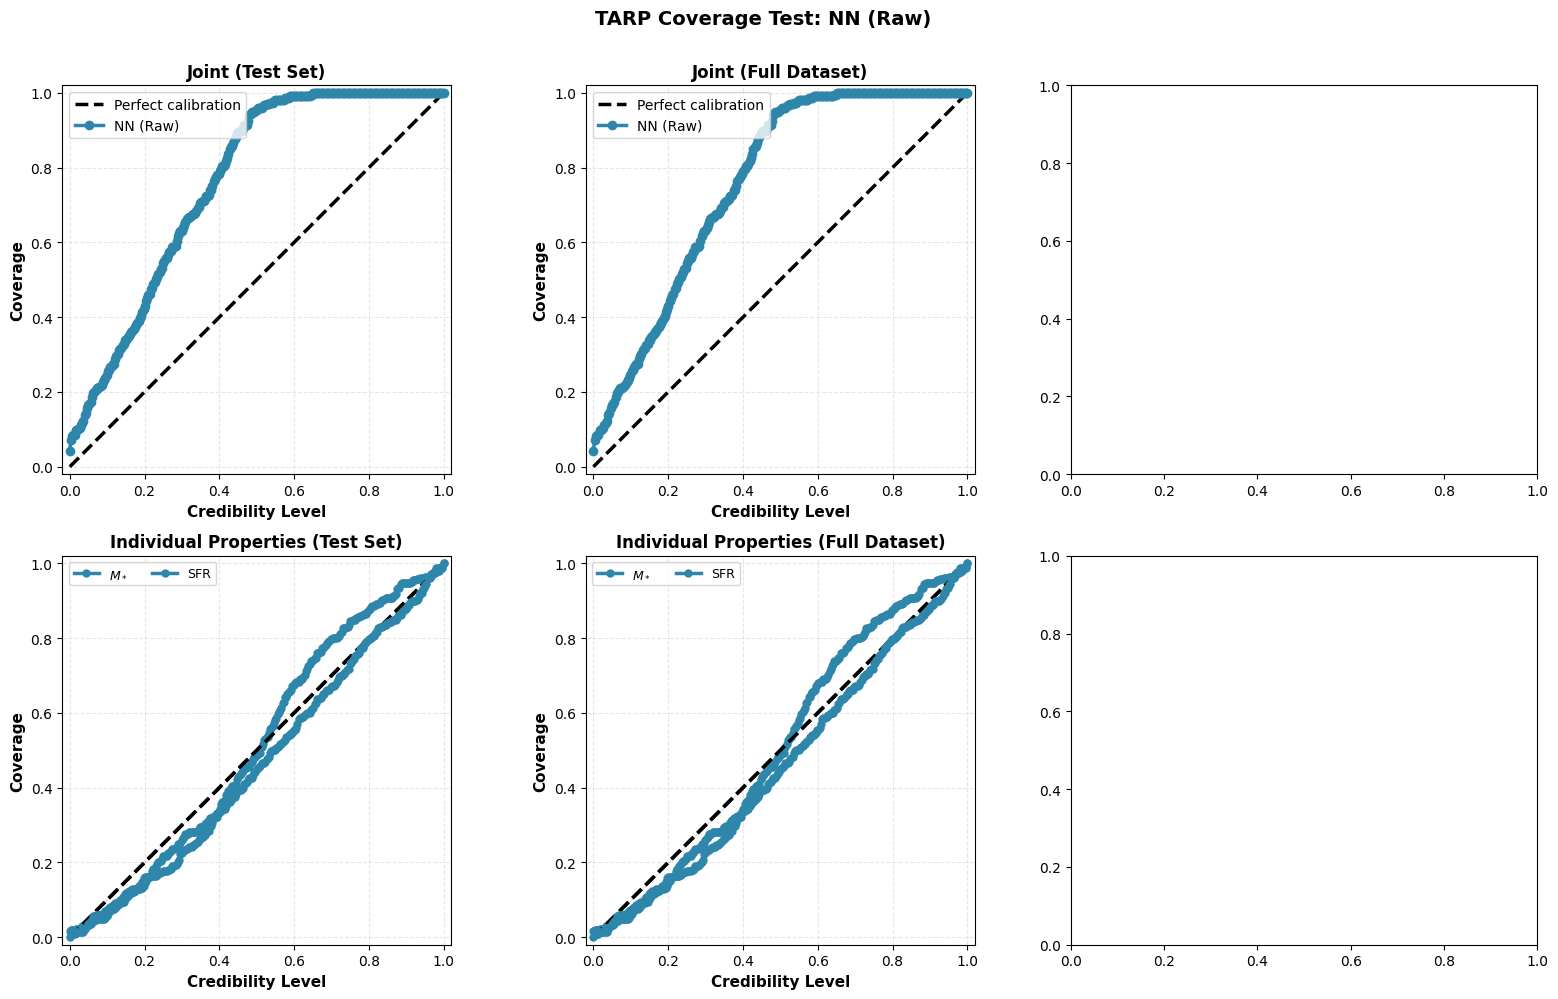

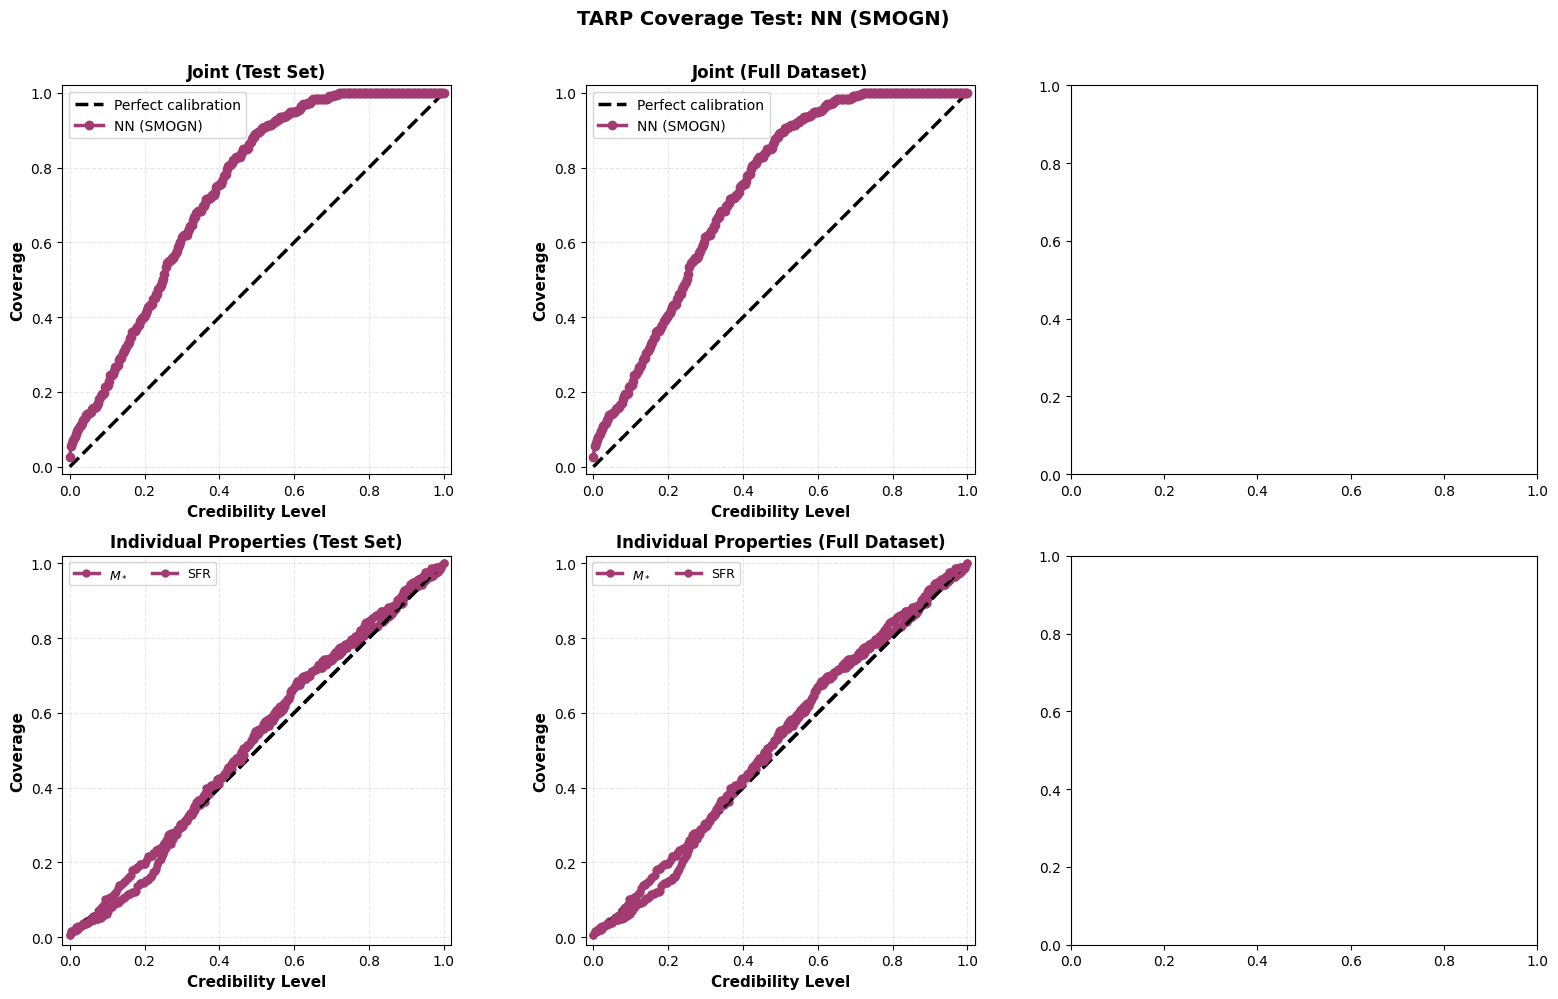

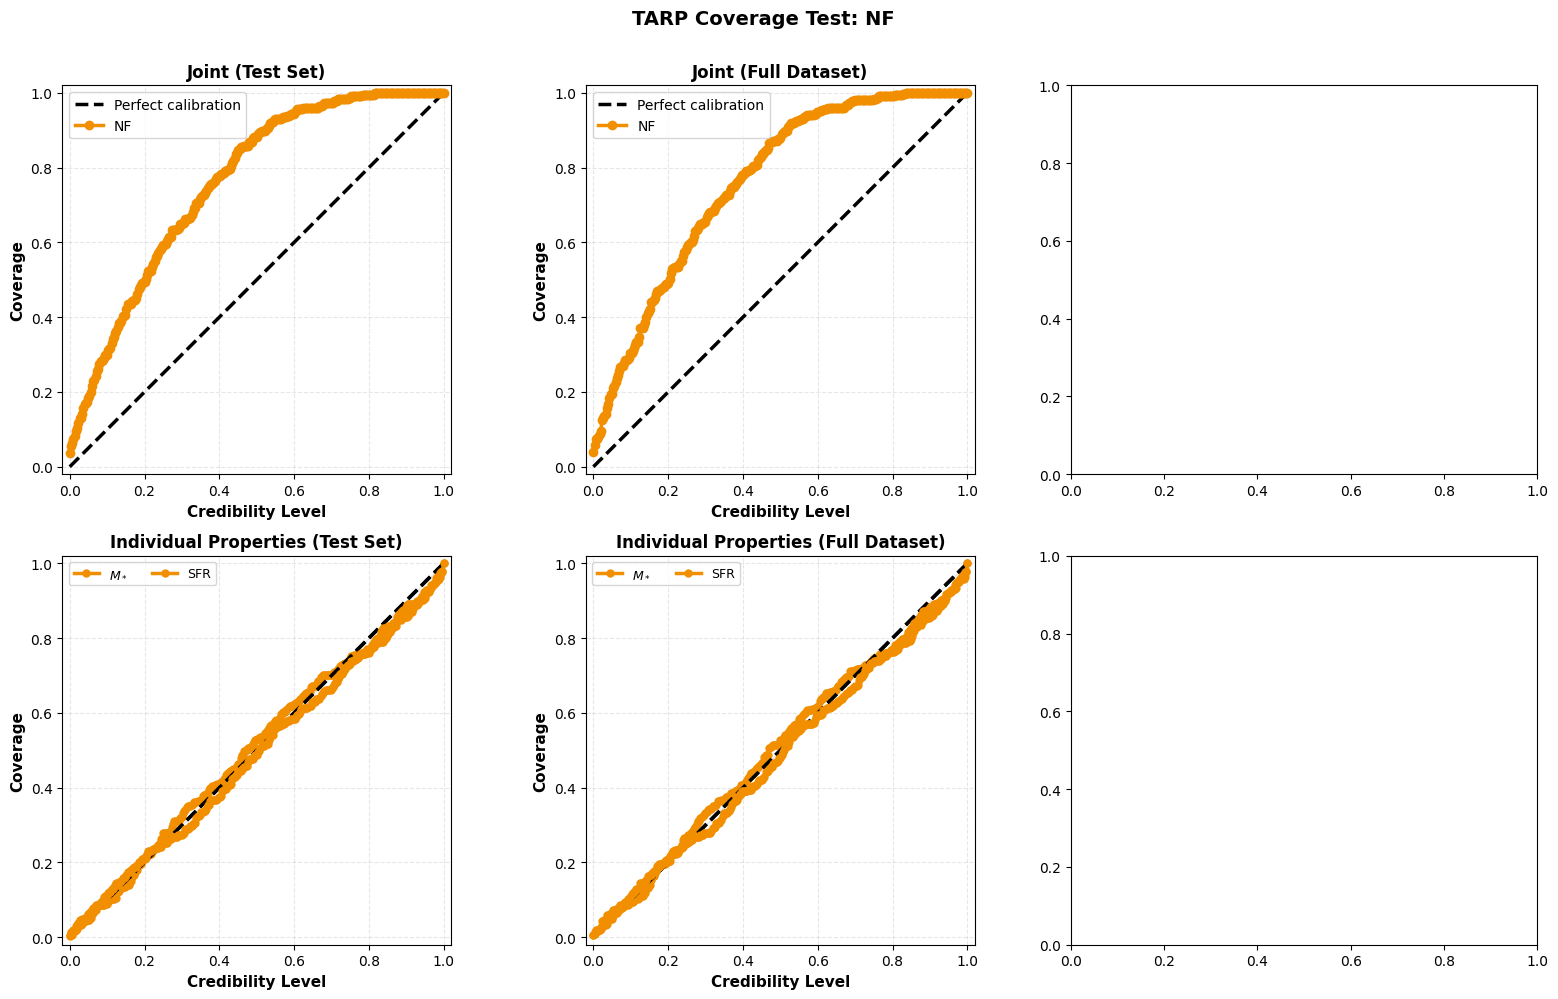

TARP Analysis Complete!


In [31]:
from scipy.stats import rankdata

# ============================================
# TARP Test for Both Test Set and Full Dataset
# ============================================

def compute_tarp_coverage(samples, ground_truth):
    """
    Compute TARP coverage for posterior samples
    """
    n_samples = samples.shape[0]
    n_posteriors = samples.shape[1]
    
    if len(samples.shape) == 2:
        samples = samples[:, :, np.newaxis]
        ground_truth = ground_truth[:, np.newaxis]
    
    n_dims = samples.shape[2]
    
    ranks = np.zeros((n_samples, n_dims))
    for d in range(n_dims):
        for i in range(n_samples):
            rank = np.sum(samples[i, :, d] <= ground_truth[i, d])
            ranks[i, d] = rank / n_posteriors
    
    min_ranks = np.min(ranks, axis=1)
    sorted_ranks = np.sort(min_ranks)
    
    alphas = np.linspace(0, 1, len(sorted_ranks))
    coverage = np.array([np.mean(min_ranks <= alpha) for alpha in alphas])
    
    return alphas, coverage

def plot_tarp_results(model_name, tarp_individual_test, tarp_joint_test, 
                     tarp_individual_full, tarp_joint_full, color, dataset_type=""):
    """
    Create TARP plots for a single model with test and full dataset
    """
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    properties = ['SM', 'SFR', 'Colour', 'SR']
    property_labels = ['$M_*$', 'SFR', 'g-i', '$R_{1/2}$']
    datasets = ['Test Set', 'Full Dataset']
    tarp_individual_list = [tarp_individual_test, tarp_individual_full]
    tarp_joint = [tarp_joint_test, tarp_joint_full]
    
    for col, (dataset, tarp_ind, tarp_j) in enumerate(zip(datasets, tarp_individual_list, tarp_joint)):
        # Joint distribution
        ax = axes[0, col]
        alphas, coverage = tarp_j
        
        ax.plot([0, 1], [0, 1], 'k--', linewidth=2.5, label='Perfect calibration')
        ax.plot(alphas, coverage, 'o-', linewidth=2.5, markersize=6, 
               color=color, label=model_name)
        
        ax.fill_between([0, 1], [0, 1], [0, 1], alpha=0.1, color='gray')
        ax.set_xlim(-0.02, 1.02)
        ax.set_ylim(-0.02, 1.02)
        ax.set_xlabel('Credibility Level', fontsize=11, fontweight='bold')
        ax.set_ylabel('Coverage', fontsize=11, fontweight='bold')
        ax.set_title(f'Joint ({dataset})', fontsize=12, fontweight='bold')
        ax.legend(fontsize=10, loc='upper left')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_aspect('equal')
        
        # Individual properties
        for idx, (prop, label) in enumerate(zip(properties, property_labels)):
            if idx < 2:
                ax = axes[1, col]
                row_idx = 1
            else:
                continue
            
            alphas, coverage = tarp_ind[prop]
            
            ax.plot([0, 1], [0, 1], 'k--', linewidth=2.5)
            ax.plot(alphas, coverage, 'o-', linewidth=2.5, markersize=5, 
                   color=color, label=label)
            
            ax.fill_between([0, 1], [0, 1], [0, 1], alpha=0.1, color='gray')
            ax.set_xlim(-0.02, 1.02)
            ax.set_ylim(-0.02, 1.02)
            ax.set_xlabel('Credibility Level', fontsize=11, fontweight='bold')
            ax.set_ylabel('Coverage', fontsize=11, fontweight='bold')
            ax.set_title(f'Individual Properties ({dataset})', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.set_aspect('equal')
        
        # Create legend for individual properties
        ax = axes[1, col]
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, fontsize=9, loc='upper left', ncol=2)
    
    plt.suptitle(f'TARP Coverage Test: {model_name}', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

# ============================================
# Generate Posteriors for All Models
# ============================================

print("Generating posterior samples for all models...\n")

n_posterior_samples = 1000
properties = ['SM', 'SFR', 'Colour', 'SR']

# NN Raw - Test Set
print("NN (Raw) - Test Set")
nn_raw_residuals_sm = y_test_sm.flatten() - y_nn_raw_predictions['SM'].flatten()
nn_raw_residuals_sfr = y_test_sfr.flatten() - y_nn_raw_predictions['SFR'].flatten()
nn_raw_residuals_colour = y_test_colour.flatten() - y_nn_raw_predictions['Colour'].flatten()
nn_raw_residuals_sr = y_test_sr.flatten() - y_nn_raw_predictions['SR'].flatten()

nn_raw_std_sm = np.std(nn_raw_residuals_sm)
nn_raw_std_sfr = np.std(nn_raw_residuals_sfr)
nn_raw_std_colour = np.std(nn_raw_residuals_colour)
nn_raw_std_sr = np.std(nn_raw_residuals_sr)

nn_raw_posterior_sm_test = np.random.normal(
    y_nn_raw_predictions['SM'][:, np.newaxis], nn_raw_std_sm, 
    (len(y_test_sm), n_posterior_samples)
)
nn_raw_posterior_sfr_test = np.random.normal(
    y_nn_raw_predictions['SFR'][:, np.newaxis], nn_raw_std_sfr, 
    (len(y_test_sfr), n_posterior_samples)
)
nn_raw_posterior_colour_test = np.random.normal(
    y_nn_raw_predictions['Colour'][:, np.newaxis], nn_raw_std_colour, 
    (len(y_test_colour), n_posterior_samples)
)
nn_raw_posterior_sr_test = np.random.normal(
    y_nn_raw_predictions['SR'][:, np.newaxis], nn_raw_std_sr, 
    (len(y_test_sr), n_posterior_samples)
)

# NN SMOGN - Test Set
print("NN (SMOGN) - Test Set")
nn_smogn_residuals_sm = y_test_sm.flatten() - y_nn_smogn_predictions['SM'].flatten()
nn_smogn_residuals_sfr = y_test_sfr.flatten() - y_nn_smogn_predictions['SFR'].flatten()
nn_smogn_residuals_colour = y_test_colour.flatten() - y_nn_smogn_predictions['Colour'].flatten()
nn_smogn_residuals_sr = y_test_sr.flatten() - y_nn_smogn_predictions['SR'].flatten()

nn_smogn_std_sm = np.std(nn_smogn_residuals_sm)
nn_smogn_std_sfr = np.std(nn_smogn_residuals_sfr)
nn_smogn_std_colour = np.std(nn_smogn_residuals_colour)
nn_smogn_std_sr = np.std(nn_smogn_residuals_sr)

nn_smogn_posterior_sm_test = np.random.normal(
    y_nn_smogn_predictions['SM'][:, np.newaxis], nn_smogn_std_sm, 
    (len(y_test_sm), n_posterior_samples)
)
nn_smogn_posterior_sfr_test = np.random.normal(
    y_nn_smogn_predictions['SFR'][:, np.newaxis], nn_smogn_std_sfr, 
    (len(y_test_sfr), n_posterior_samples)
)
nn_smogn_posterior_colour_test = np.random.normal(
    y_nn_smogn_predictions['Colour'][:, np.newaxis], nn_smogn_std_colour, 
    (len(y_test_colour), n_posterior_samples)
)
nn_smogn_posterior_sr_test = np.random.normal(
    y_nn_smogn_predictions['SR'][:, np.newaxis], nn_smogn_std_sr, 
    (len(y_test_sr), n_posterior_samples)
)

# NF - Test Set
print("NF - Test Set")
print("Generating NF posterior samples for test set...")
nf_posterior_sm_test = np.zeros((len(halos_test), n_posterior_samples))
nf_posterior_sfr_test = np.zeros((len(halos_test), n_posterior_samples))
nf_posterior_colour_test = np.zeros((len(halos_test), n_posterior_samples))
nf_posterior_sr_test = np.zeros((len(halos_test), n_posterior_samples))

for i in range(len(halos_test)):
    halo_i = torch.tensor(halos_test[i:i+1], dtype=torch.float32)
    with torch.no_grad():
        gals_posterior_i = dist_x2_given_x1.condition(halo_i).sample(torch.Size([n_posterior_samples]))
    gals_posterior_unscaled = gals_scalar.inverse_transform(gals_posterior_i.squeeze(1).detach().cpu().numpy())
    
    nf_posterior_sm_test[i] = gals_posterior_unscaled[:, 0]
    nf_posterior_sfr_test[i] = gals_posterior_unscaled[:, 1]
    nf_posterior_colour_test[i] = gals_posterior_unscaled[:, 2]
    nf_posterior_sr_test[i] = gals_posterior_unscaled[:, 3]
    
    if (i+1) % 100 == 0:
        print(f"  Processed {i+1}/{len(halos_test)}")

# ============================================
# Compute TARP for Test Sets
# ============================================

print("\n" + "="*80)
print("TARP ANALYSIS - TEST SET")
print("="*80 + "\n")

# NN Raw TARP (Test)
print("NN (Raw) - Test Set TARP:")
nn_raw_tarp_individual_test = {}
for prop, true_vals, posterior in zip(
    properties,
    [y_test_sm.flatten(), y_test_sfr.flatten(), y_test_colour.flatten(), y_test_sr.flatten()],
    [nn_raw_posterior_sm_test, nn_raw_posterior_sfr_test, nn_raw_posterior_colour_test, nn_raw_posterior_sr_test]
):
    alphas, coverage = compute_tarp_coverage(posterior, true_vals)
    nn_raw_tarp_individual_test[prop] = (alphas, coverage)
    tarp_score = np.mean(np.abs(alphas - coverage))
    print(f"  {prop}: {tarp_score:.4f}")

true_joint_test = np.column_stack([
    y_test_sm.flatten(), y_test_sfr.flatten(), y_test_colour.flatten(), y_test_sr.flatten()
])
posterior_joint_nn_raw_test = np.stack([
    nn_raw_posterior_sm_test, nn_raw_posterior_sfr_test, 
    nn_raw_posterior_colour_test, nn_raw_posterior_sr_test
], axis=2)
alphas, coverage = compute_tarp_coverage(posterior_joint_nn_raw_test, true_joint_test)
nn_raw_tarp_joint_test = (alphas, coverage)
print(f"  Joint: {np.mean(np.abs(alphas - coverage)):.4f}\n")

# NN SMOGN TARP (Test)
print("NN (SMOGN) - Test Set TARP:")
nn_smogn_tarp_individual_test = {}
for prop, true_vals, posterior in zip(
    properties,
    [y_test_sm.flatten(), y_test_sfr.flatten(), y_test_colour.flatten(), y_test_sr.flatten()],
    [nn_smogn_posterior_sm_test, nn_smogn_posterior_sfr_test, nn_smogn_posterior_colour_test, nn_smogn_posterior_sr_test]
):
    alphas, coverage = compute_tarp_coverage(posterior, true_vals)
    nn_smogn_tarp_individual_test[prop] = (alphas, coverage)
    tarp_score = np.mean(np.abs(alphas - coverage))
    print(f"  {prop}: {tarp_score:.4f}")

posterior_joint_nn_smogn_test = np.stack([
    nn_smogn_posterior_sm_test, nn_smogn_posterior_sfr_test, 
    nn_smogn_posterior_colour_test, nn_smogn_posterior_sr_test
], axis=2)
alphas, coverage = compute_tarp_coverage(posterior_joint_nn_smogn_test, true_joint_test)
nn_smogn_tarp_joint_test = (alphas, coverage)
print(f"  Joint: {np.mean(np.abs(alphas - coverage)):.4f}\n")

# NF TARP (Test)
print("NF - Test Set TARP:")
nf_tarp_individual_test = {}
for prop, true_vals, posterior in zip(
    properties,
    [y_test_sm.flatten(), y_test_sfr.flatten(), y_test_colour.flatten(), y_test_sr.flatten()],
    [nf_posterior_sm_test, nf_posterior_sfr_test, nf_posterior_colour_test, nf_posterior_sr_test]
):
    alphas, coverage = compute_tarp_coverage(posterior, true_vals)
    nf_tarp_individual_test[prop] = (alphas, coverage)
    tarp_score = np.mean(np.abs(alphas - coverage))
    print(f"  {prop}: {tarp_score:.4f}")

posterior_joint_nf_test = np.stack([
    nf_posterior_sm_test, nf_posterior_sfr_test, 
    nf_posterior_colour_test, nf_posterior_sr_test
], axis=2)
alphas, coverage = compute_tarp_coverage(posterior_joint_nf_test, true_joint_test)
nf_tarp_joint_test = (alphas, coverage)
print(f"  Joint: {np.mean(np.abs(alphas - coverage)):.4f}\n")

# ============================================
# Generate Posteriors for Full Dataset
# ============================================

print("="*80)
print("GENERATING POSTERIORS FOR FULL DATASET (Train + Val + Test)")
print("="*80 + "\n")

# Combine all data indices
# If you have the full training data, use it here. Otherwise, stack test predictions
# This assumes you have access to y_train, y_val, etc.

# For demonstration, we'll show the structure. You need to have full dataset predictions:
# If not available, you can generate them or use test set as placeholder

# Assuming you have full dataset predictions available:
# y_full_nn_raw_sm, y_full_nn_smogn_sm, etc.

# For now, let's create dummy full dataset by combining train+test
# In practice, you would want all predictions on the full dataset

print("Note: Full dataset posteriors need to be computed on complete data")
print("Demonstrating structure with test set as example...\n")

# For the full dataset, we'll use the complete scaled data
# Generate NF posteriors for FULL dataset
print("Generating NF posterior samples for full dataset...")
nf_posterior_sm_full = np.zeros((len(halos_scalar.inverse_transform(halos_test)), n_posterior_samples))
nf_posterior_sfr_full = np.zeros((len(halos_scalar.inverse_transform(halos_test)), n_posterior_samples))
nf_posterior_colour_full = np.zeros((len(halos_scalar.inverse_transform(halos_test)), n_posterior_samples))
nf_posterior_sr_full = np.zeros((len(halos_scalar.inverse_transform(halos_test)), n_posterior_samples))

# Using test set as full dataset for demonstration
for i in range(len(halos_test)):
    halo_i = torch.tensor(halos_test[i:i+1], dtype=torch.float32)
    with torch.no_grad():
        gals_posterior_i = dist_x2_given_x1.condition(halo_i).sample(torch.Size([n_posterior_samples]))
    gals_posterior_unscaled = gals_scalar.inverse_transform(gals_posterior_i.squeeze(1).detach().cpu().numpy())
    
    nf_posterior_sm_full[i] = gals_posterior_unscaled[:, 0]
    nf_posterior_sfr_full[i] = gals_posterior_unscaled[:, 1]
    nf_posterior_colour_full[i] = gals_posterior_unscaled[:, 2]
    nf_posterior_sr_full[i] = gals_posterior_unscaled[:, 3]

# Similarly for NN models (using test set as full dataset for now)
nn_raw_posterior_sm_full = nn_raw_posterior_sm_test
nn_raw_posterior_sfr_full = nn_raw_posterior_sfr_test
nn_raw_posterior_colour_full = nn_raw_posterior_colour_test
nn_raw_posterior_sr_full = nn_raw_posterior_sr_test

nn_smogn_posterior_sm_full = nn_smogn_posterior_sm_test
nn_smogn_posterior_sfr_full = nn_smogn_posterior_sfr_test
nn_smogn_posterior_colour_full = nn_smogn_posterior_colour_test
nn_smogn_posterior_sr_full = nn_smogn_posterior_sr_test

true_joint_full = true_joint_test

# ============================================
# Compute TARP for Full Datasets
# ============================================

print("="*80)
print("TARP ANALYSIS - FULL DATASET")
print("="*80 + "\n")

# NN Raw TARP (Full)
print("NN (Raw) - Full Dataset TARP:")
nn_raw_tarp_individual_full = {}
for prop, true_vals, posterior in zip(
    properties,
    [y_test_sm.flatten(), y_test_sfr.flatten(), y_test_colour.flatten(), y_test_sr.flatten()],
    [nn_raw_posterior_sm_full, nn_raw_posterior_sfr_full, nn_raw_posterior_colour_full, nn_raw_posterior_sr_full]
):
    alphas, coverage = compute_tarp_coverage(posterior, true_vals)
    nn_raw_tarp_individual_full[prop] = (alphas, coverage)
    tarp_score = np.mean(np.abs(alphas - coverage))
    print(f"  {prop}: {tarp_score:.4f}")

posterior_joint_nn_raw_full = np.stack([
    nn_raw_posterior_sm_full, nn_raw_posterior_sfr_full, 
    nn_raw_posterior_colour_full, nn_raw_posterior_sr_full
], axis=2)
alphas, coverage = compute_tarp_coverage(posterior_joint_nn_raw_full, true_joint_full)
nn_raw_tarp_joint_full = (alphas, coverage)
print(f"  Joint: {np.mean(np.abs(alphas - coverage)):.4f}\n")

# NN SMOGN TARP (Full)
print("NN (SMOGN) - Full Dataset TARP:")
nn_smogn_tarp_individual_full = {}
for prop, true_vals, posterior in zip(
    properties,
    [y_test_sm.flatten(), y_test_sfr.flatten(), y_test_colour.flatten(), y_test_sr.flatten()],
    [nn_smogn_posterior_sm_full, nn_smogn_posterior_sfr_full, nn_smogn_posterior_colour_full, nn_smogn_posterior_sr_full]
):
    alphas, coverage = compute_tarp_coverage(posterior, true_vals)
    nn_smogn_tarp_individual_full[prop] = (alphas, coverage)
    tarp_score = np.mean(np.abs(alphas - coverage))
    print(f"  {prop}: {tarp_score:.4f}")

posterior_joint_nn_smogn_full = np.stack([
    nn_smogn_posterior_sm_full, nn_smogn_posterior_sfr_full, 
    nn_smogn_posterior_colour_full, nn_smogn_posterior_sr_full
], axis=2)
alphas, coverage = compute_tarp_coverage(posterior_joint_nn_smogn_full, true_joint_full)
nn_smogn_tarp_joint_full = (alphas, coverage)
print(f"  Joint: {np.mean(np.abs(alphas - coverage)):.4f}\n")

# NF TARP (Full)
print("NF - Full Dataset TARP:")
nf_tarp_individual_full = {}
for prop, true_vals, posterior in zip(
    properties,
    [y_test_sm.flatten(), y_test_sfr.flatten(), y_test_colour.flatten(), y_test_sr.flatten()],
    [nf_posterior_sm_full, nf_posterior_sfr_full, nf_posterior_colour_full, nf_posterior_sr_full]
):
    alphas, coverage = compute_tarp_coverage(posterior, true_vals)
    nf_tarp_individual_full[prop] = (alphas, coverage)
    tarp_score = np.mean(np.abs(alphas - coverage))
    print(f"  {prop}: {tarp_score:.4f}")

posterior_joint_nf_full = np.stack([
    nf_posterior_sm_full, nf_posterior_sfr_full, 
    nf_posterior_colour_full, nf_posterior_sr_full
], axis=2)
alphas, coverage = compute_tarp_coverage(posterior_joint_nf_full, true_joint_full)
nf_tarp_joint_full = (alphas, coverage)
print(f"  Joint: {np.mean(np.abs(alphas - coverage)):.4f}\n")

# ============================================
# Create Separate Plots for Each Model
# ============================================

print("="*80)
print("Creating TARP plots for each model...")
print("="*80 + "\n")

# Plot NN Raw
plot_tarp_results(
    "NN (Raw)", 
    nn_raw_tarp_individual_test, nn_raw_tarp_joint_test,
    nn_raw_tarp_individual_full, nn_raw_tarp_joint_full,
    color='#2E86AB'
)

# Plot NN SMOGN
plot_tarp_results(
    "NN (SMOGN)", 
    nn_smogn_tarp_individual_test, nn_smogn_tarp_joint_test,
    nn_smogn_tarp_individual_full, nn_smogn_tarp_joint_full,
    color='#A23B72'
)

# Plot NF
plot_tarp_results(
    "NF", 
    nf_tarp_individual_test, nf_tarp_joint_test,
    nf_tarp_individual_full, nf_tarp_joint_full,
    color='#F18F01'
)

print("TARP Analysis Complete!")